# Introduction to the Study

The financial markets are a web of complexities, where the Federal Reserve's announcements play a crucial role in influencing market dynamics. This project delves into the nuanced relationship between these Federal Reserve releases and market behavior, with a particular focus on the SPDR S&P 500 ETF Trust (SPY) as a lens through which to view the market's pulse. The intrigue of this study is rooted in a quest to unravel the mysteries of how authoritative financial communications impact market performance. Despite a rich tapestry of research, the specific ways in which Fed announcements sway market sentiment and behavior remain elusive, sparking the motivation behind this exploration.

## Project Contributions

This project distinguishes itself through a unique journey of data acquisition, analysis, and application:

- **Data Scraping and Quality Challenges**: Initially, we attempted to use FedTools (https://github.com/David-Woroniuk/FedTools) for scraping Federal Reserve communications. However, this method yielded data of poor quality, with information inaccurately placed and significant omissions. This setback led us to a more direct approach, scraping data from the Federal Reserve's website using existing code from GitHub, which we adapted for our purposes. This approach ensured transparency and integrity in our data collection process.

- **Sentiment Analysis Innovation**: Following data acquisition, we embarked on sentiment analysis, employing the Loughran-McDonald Master Dictionary (https://sraf.nd.edu/loughranmcdonald-master-dictionary/)  with Sentiment Word Lists to quantify the tone of Federal Reserve communications, translating qualitative data into quantifiable metrics for empirical analysis. To ensure the robustness of our sentiment analysis, we paralleled our primary methodology with the "vaderSentiment" library (https://vadersentiment.readthedocs.io/en/latest/pages/about_the_scoring.html). Although this validation step confirmed the consistency of our results, it was excluded from the final presentation due to computational intensity, prioritizing reproducibility.

- **Data Preprocessing and Feature Engineering**: After importing SPY data, we conducted thorough data preprocessing, adding new features to enrich our analysis. This step was pivotal in crafting a robust trading strategy.

- **Model Testing and Optimization**: Upon completing the preprocessing phase, we embarked on a rigorous evaluation of various machine learning models. Our objective was twofold: firstly, to classify market conditions into three distinct regimes, providing a nuanced understanding of market dynamics; secondly, to employ predictive models capable of forecasting future stock returns with enhanced accuracy. In pursuit of optimizing our models' performance, we explored the advanced technique of model stacking. This approach allowed us to leverage the strengths of individual models, combining them in a manner that produced superior predictive power and more reliable insights into future market behavior.


- **Trading Strategy Development**: Initially, our trading strategy did not incorporate sentiment analysis findings. However, recognizing the potential value of sentiment data, we revised our strategy to include it, aiming to assess its impact on trading effectiveness.

## Empirical Findings Summary

Our empirical exploration uncovered a statistically significant correlation between the sentiment of Federal Reserve communications and movements in the SPDR S&P 500 ETF Trust (SPY). This discovery not only demonstrates the economic influence of Fed announcements but also showcases the predictive potential of sentiment analysis in financial markets.


# *Installing the libraries*

In [ ]:
import subprocess

def install(package):
    subprocess.run(["pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

packages = [
    "gym",
    "stable-baselines3 torch",
    "requests beautifulsoup4 pandas nltk sklearn",
    "shimmy",
    "mplfinance",
    "selenium",
    "webdriver-manager",
    "catboost",
    "FedTools",
    "vaderSentiment"

]

for package in packages:
    install(package)


# Importing the libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import concurrent.futures
import os
from urllib.parse import urljoin

import yfinance as yf
import pandas as pd
import mplfinance as mpf

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gym
from gym import spaces

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifierCV
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from FedTools import MonetaryPolicyCommittee
from FedTools import FederalReserveMins
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Data scrapping:

As mentioned in our introductory section, a portion of the code used in this project was not originally developed by our team; it represents the only instance of external code adoption throughout our entire project. Specifically, the initial scraping code was sourced from two distinct repositories:

- The first script, dedicated to scraping FOMC Statements, was adapted from [this GitHub repository](https://github.com/tengtengtengteng/Webscraping-FOMC-Statements/blob/main/Without_Selenium.py).
- The second script, focused on Federal Reserve Minutes Topic and Sentiment Modeling, was taken from [another GitHub repository](https://github.com/JonnyFLDN/Federal-Reserve-Minutes-Topic-and-Sentiment-Modelling/blob/master/WebScraper.py).

These scripts were carefully modified to align with the specific requirements and objectives of our project.




In [ ]:

def fetch_content(url):
    """
    Fetches and parses content from a given URL.
    """
    response = requests.get(url)
    return BeautifulSoup(response.content, 'lxml')

# Define base URL and specific paths
base_url = "http://www.federalreserve.gov"
date_url = "/monetarypolicy/fomccalendars.htm"

# Fetch and parse the main FOMC calendar page
date_soup = fetch_content(base_url + date_url)

# Initialize list to hold statement URLs
statement_url_list = []

# Find the meeting dates and statement URLs
meetings = date_soup.find_all('div', class_='col-xs-12 col-md-4 col-lg-2')
for meeting in meetings:
    statement = meeting.find('a', text='HTML')
    if statement:
        statement_url_list.append(statement['href'])

# Fetch historical statements
historical_url = "/monetarypolicy/fomchistorical{}.htm"
for year in range(2015, 2008, -1):
    year_soup = fetch_content(base_url + historical_url.format(year))
    links = year_soup.find_all('div', class_='col-xs-12 col-md-6')
    for link in links:
        statement = link.find('a', text='Statement')
        if statement:
            statement_url_list.append(statement['href'])

# Initialize lists to hold dates and statement texts
date_list = []
statement_list = []

# Fetch and parse each statement page
for statement_url in statement_url_list:
    statement_soup = fetch_content(base_url + statement_url)
    article = statement_soup.find('div', class_='col-xs-12 col-sm-8 col-md-8').text
    date = statement_url[-13:-5]  # Extract date from URL
    statement_list.append(article.strip())
    date_list.append(date)

# Save as DataFrame, process dates, sort, and output to CSV
df_statements = pd.DataFrame(list(zip(date_list, statement_list)), columns=['Date', 'Statement'])
df_statements['Date'] = pd.to_datetime(df_statements['Date'], format='%Y%m%d')

<ipython-input-43-0885d20d9c60>:21: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  statement = meeting.find('a', text='HTML')


In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import re
from urllib.parse import urljoin
import concurrent.futures


class FedMinScraper(object):
    """
    The purpose of this class is to extract monthly US federal reserve minutes

    Parameters
    ----------
    dates: list('yyyy'|'yyyy-mm')
        List of strings/integers referencing dates for extraction
        Example:
        dates = [min_year] -> Extracts all transcripts for this year
        dates = [min_year,max_year] -> Extracts transactions for a set of years
        dates = ['2020-01'] -> Extracts transcripts for a single month/year

    nthreads: int
        Set of threads used for multiprocessing
        defaults to None

    Returns
    --------
    transcripts: txt files

    """

    url_parent = r"https://www.federalreserve.gov/monetarypolicy/"
    url_current = r"fomccalendars.htm"

    # historical transcripts are stored differently
    url_historical = r"fomchistorical{}.htm"
    # each transcript has a unique address, gathered from url_current or url_historical
    url_transcript = r"fomcminutes{}.htm"
    href_regex = re.compile("(?i)/fomc[/]?minutes[/]?\d{8}.htm")

    def __init__(self, dates, nthreads=5, save_path=None):

        # make sure user has given list with strings
        if not isinstance(dates, list):
            raise TypeError("dates should be a list of yyyy or yyyymm str/int")

        elif not all([bool(re.search(r"^\d{4}$|^\d{6}$", str(d))) for d in dates]):
            raise ValueError("dates should be in a yyyy or yyyymm format")

        self.dates = dates
        self.nthreads = nthreads
        self.save_path = save_path

        self.ndates = len(dates)
        self.years = [int(d[:4]) for d in dates]
        self.min_year, self.max_year = min(self.years), max(self.years)
        self.transcript_dates = []
        self.transcripts = {}
        self.historical_date = None

        self._get_transcript_dates()
        self.start_threading()

        # Instead of saving, convert to DataFrame
        self.df = self.to_dataframe()  # Store the DataFrame as an attribute of the class

        # Optionally, you can still keep the save_transcript functionality
        if save_path:
            self.save_transcript()

    def _get_transcript_dates(self):
        """
        Extract all links for
        """

        r = requests.get(urljoin(FedMinScraper.url_parent, FedMinScraper.url_current))
        soup = BeautifulSoup(r.text, "lxml")
        # dates are given by yyyymmdd

        tdates = soup.findAll("a", href=self.href_regex)
        tdates = [re.search(r"\d{8}", str(t))[0] for t in tdates]
        self.historical_date = int(min(tdates)[:4])
        # find minimum year

        # extract all of these and filter
        # tdates can only be applied to /fomcminutes
        # historical dates need to be applied to federalreserve.gov

        if self.min_year < self.historical_date:
            # just append the years i'm interested in
            for y in range(self.min_year, self.historical_date + 1):

                r = requests.get(
                    urljoin(
                        FedMinScraper.url_parent, FedMinScraper.url_historical.format(y)
                    )
                )
                soup = BeautifulSoup(r.text, parser="lxml")
                hdates = soup.find_all("a", href=self.href_regex)
                tdates.extend([re.search(r"\d{8}", str(t))[0] for t in hdates])

        self.transcript_dates = tdates

    def get_transcript(self, transcript_date):

        transcript_url = urljoin(
            FedMinScraper.url_parent,
            FedMinScraper.url_transcript.format(transcript_date),
        )
        r = requests.get(transcript_url)

        if not r.ok:
            transcript_url = urljoin(
                FedMinScraper.url_parent.replace("/monetarypolicy", ""),
                r"fomc/minutes/{}.htm".format(transcript_date),
            )
            r = requests.get(transcript_url)

        soup = BeautifulSoup(r.content, "lxml")
        main_text = soup.findAll(name="p")

        clean_main_text = "\n\n".join(t.text.strip() for t in main_text)

        # reduce double spaces to one
        clean_main_text = re.sub(r"  ", r" ", clean_main_text)

        self.transcripts[transcript_date] = clean_main_text

    def start_threading(self):
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.nthreads) as executor:
            executor.map(self.get_transcript, self.transcript_dates)

    def save_transcript(self):
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        for fname, txt in self.transcripts.items():
            with open(
                os.path.join(self.save_path, fname + ".txt"), "w", encoding="utf-8"
            ) as o:
                o.write(txt)
                o.close()
    def to_dataframe(self):
        """
        Converts the transcripts dictionary into a pandas DataFrame

        Returns
        -------
        df : pandas.DataFrame
            A DataFrame with two columns: 'Date' and 'Transcript'
        """
        # Convert the transcripts dictionary into a DataFrame
        df = pd.DataFrame(list(self.transcripts.items()), columns=['Date', 'Transcript'])
        return df




if __name__ == "__main__":

  dates = ["2004", "2021"]
  save_path = os.path.join(os.getcwd(), "Minutes")
  FMS = FedMinScraper(dates=dates, save_path=save_path)
  print(FMS.df)  # This will print the DataFrame with dates and transcripts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:39: DeprecationWarning: invalid escape sequence '\d'


         Date                                         Transcript
0    20230726  The Federal Reserve, the central bank of the U...
1    20230503  The Federal Reserve, the central bank of the U...
2    20230201  The Federal Reserve, the central bank of the U...
3    20230614  The Federal Reserve, the central bank of the U...
4    20230322  The Federal Reserve, the central bank of the U...
..        ...                                                ...
154  20180801  The Federal Reserve, the central bank of the U...
155  20180613  The Federal Reserve, the central bank of the U...
156  20180926  The Federal Reserve, the central bank of the U...
157  20181108  The Federal Reserve, the central bank of the U...
158  20181219  The Federal Reserve, the central bank of the U...

[159 rows x 2 columns]


In [ ]:
df_minutes =FMS.df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_minutes['Date'] = pd.to_datetime(df_minutes['Date'], format='%Y%m%d')
df_minutes

,Date,Transcript
0,2023-07-26,"The Federal Reserve, the central bank of the U..."
1,2023-05-03,"The Federal Reserve, the central bank of the U..."
2,2023-02-01,"The Federal Reserve, the central bank of the U..."
3,2023-06-14,"The Federal Reserve, the central bank of the U..."
4,2023-03-22,"The Federal Reserve, the central bank of the U..."
...,...,...
154,2018-08-01,"The Federal Reserve, the central bank of the U..."
155,2018-06-13,"The Federal Reserve, the central bank of the U..."
156,2018-09-26,"The Federal Reserve, the central bank of the U..."
157,2018-11-08,"The Federal Reserve, the central bank of the U..."


In [ ]:
df_statements.set_index('Date', inplace=True)
df_minutes.set_index('Date', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
statement_per_year = df_statements.resample('Y').count()
print(statement_per_year)

In [ ]:
Minute_per_year = df_minutes.resample('Y').count()
print(statement_per_year)

**Observationally, the frequency of releases typically stands at eight per annum. However, an anomaly was noted in 2020, where the count escalated to ten, attributable to the exigencies imposed by the coronavirus pandemic.**

We create here new datasets with the more recent releases (from 2010 till december 2023) by filtering the previous ones:

In [ ]:

# Define the date range
start_date = '2010-01-01'
end_date = '2023-12-28'

# Filter the DataFrame for the specified date range
df = df_minutes[(df_minutes.index >= start_date) & (df_minutes.index <= end_date)]
df1 = df_statements[(df_statements.index >= start_date) & (df_statements.index <= end_date)]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df1['Statement'].iloc[0]


"Recent indicators point to modest growth in spending and production. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation has eased somewhat but remains elevated.\nRussia's war against Ukraine is causing tremendous human and economic hardship and is contributing to elevated global uncertainty. The Committee is highly attentive to inflation risks.\nThe Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 4-1/2 to 4-3/4 percent. The Committee anticipates that ongoing increases in the target range will be appropriate in order to attain a stance of monetary policy that is sufficiently restrictive to return inflation to 2 percent over time. In determining the extent of future increases in the target range, the Committee will take into account the cumulative tightening of monetary policy, t

# **Sentiment analysis:**

In this part, we inspired from the methodology presented in the course to make the sentiment analysis for the Fed releases. We use the same dictionary (Loughran-McDonald 1993-2021) which is the latest version of available online

we begin with importing the dictinary which is available vis this link: https://sraf.nd.edu/loughranmcdonald-master-dictionary/


In [ ]:
dict_df = pd.read_csv("/content/Loughran-McDonald_MasterDictionary_1993-2021.csv")
# dict_df = pd.read_csv("https://drive.google.com/file/d/17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik/view?usp=sharing")

Creation of lists of positive and negative words from the dictionary and a list of available words ( we included the informal words just in case but they are not used in any of the releases)

In [ ]:
positive_words = dict_df[dict_df['Positive'] > 0 ]['Word'].tolist()
negative_words = dict_df[dict_df['Negative'] > 0 ]['Word'].tolist()
negation_words = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We create the functions to make the sentiment analysis in a very similar way as in the course we added a check of the existence of negation words before the words to check

In [ ]:
def negated(word, negation_words):
    """Determine if preceding word is a negation word"""
    return word.lower() in negation_words

def calculate_sentiment_score(text, positive_words, negative_words, negation_words):
    # Convert to upper case, remove punctuation, and split into words
    words = text.upper().translate(str.maketrans('', '', '.,')).split()

    # Initialize sentiment counts
    pos, neg = 0, 0

    for i, word in enumerate(words):
        if word in negative_words:
            if any(negated(words[j], negation_words) for j in range(max(0, i-3), i)):
              pos+=1
            else:
              neg += 1
        elif word in positive_words:
            # Check for negation in the 3 words preceding the current word
            if any(negated(words[j], negation_words) for j in range(max(0, i-3), i)):
                neg += 1
            else:
                pos += 1

    # Calculate the sentiment score
    score = ((pos - neg) / (pos + neg)) if (pos + neg) > 0 else 0

    return score


We apply the previous functions on the Fed releases

In [ ]:
# Apply the function to each row in the 'Federal_Reserve_Mins' column to create a new column 'Sentiment_Score'
df['Sentiment_Score_Mins'] = df['Transcript'].apply(lambda text: calculate_sentiment_score(text, positive_words, negative_words,negation_words))
df1['Sentiment_Score_FMOC'] = df1['Statement'].apply(lambda text: calculate_sentiment_score(text, positive_words, negative_words,negation_words))


<ipython-input-54-35deec4f8513>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Score_Mins'] = df['Transcript'].apply(lambda text: calculate_sentiment_score(text, positive_words, negative_words,negation_words))
<ipython-input-54-35deec4f8513>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment_Score_FMOC'] = df1['Statement'].apply(lambda text: calculate_sentiment_score(text, positive_words, negative_words,negation_words))


In [ ]:
df1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Statement,Sentiment_Score_FMOC
Date,,
2023-02-01,Recent indicators point to modest growth in sp...,0.5
2023-03-22,Recent indicators point to modest growth in sp...,1.0
2023-05-03,Economic activity expanded at a modest pace in...,1.0
2023-06-14,Recent indicators suggest that economic activi...,1.0
2023-07-26,Recent indicators suggest that economic activi...,1.0
...,...,...
2010-06-23,Information received since the Federal Open Ma...,-1.0
2010-08-10,Information received since the Federal Open Ma...,-1.0
2010-09-21,Information received since the Federal Open Ma...,-1.0


In this subsection, we create a new dataframe (final_df that will be used in the next steps) form df and df1.. Firstly, it converts the index of each DataFrame to datetime format and sorts them in chronological order. It then defines a specific date range, from January 1, 2010, to December 28, 2023, and filters the DataFrames to only include data within this range. To ensure no gaps in the dates, it reindexes the DataFrames to include all dates within the defined range, filling any missing values by carrying forward the last available value. After filtering and cleaning, it merges the two DataFrames based on their dates, calculates the average of the two sentiment scores, and retains only the date and the calculated average sentiment score for each day. Finally, the script extends the final DataFrame by appending rows with a constant sentiment score, starting from December 14, 2023, to the end of the defined date range, effectively using the sentiment score from December 13, 2023, for these new rows.

In [ ]:

df.index = pd.to_datetime(df.index).sort_values()
df1.index = pd.to_datetime(df1.index).sort_values()

start_date = '2010-01-01'
end_date = '2023-12-28'

start_date, end_date = pd.to_datetime([start_date, end_date])

# Reindex and  fill missing dates for both DataFrames simultaneously
common_end_date = max(df.index[-1], df1.index[-1])
all_dates = pd.date_range(start=min(df.index[0], df1.index[0]), end=common_end_date, freq='D')

df = df.reindex(all_dates).fillna(method='ffill')
df1 = df1.reindex(all_dates).fillna(method='ffill')

# Filter by the date range and reset index
df = df.loc[start_date:end_date].reset_index().rename(columns={'index': 'Dates'})
df1 = df1.loc[start_date:end_date].reset_index().rename(columns={'index': 'Dates'})

# Merge DataFrames and calculate the average of the values for each row
combined_df = pd.merge(df1, df, on='Dates', how='inner')
combined_df['Sentiment_Score'] = combined_df[['Sentiment_Score_Mins', 'Sentiment_Score_FMOC']].mean(axis=1)

# Create a new DataFrame with only the date and the calculated average
final_df = combined_df[['Dates', 'Sentiment_Score']]

#Extension of  the DataFrame
value_on_2023_12_13 = final_df.loc[final_df['Dates'] == '2023-12-13', 'Sentiment_Score'].iloc[0]

date_range = pd.date_range(start='2023-12-14', end=end_date)
new_rows = pd.DataFrame({'Dates': date_range, 'Sentiment_Score': value_on_2023_12_13})

final_df = pd.concat([final_df, new_rows], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


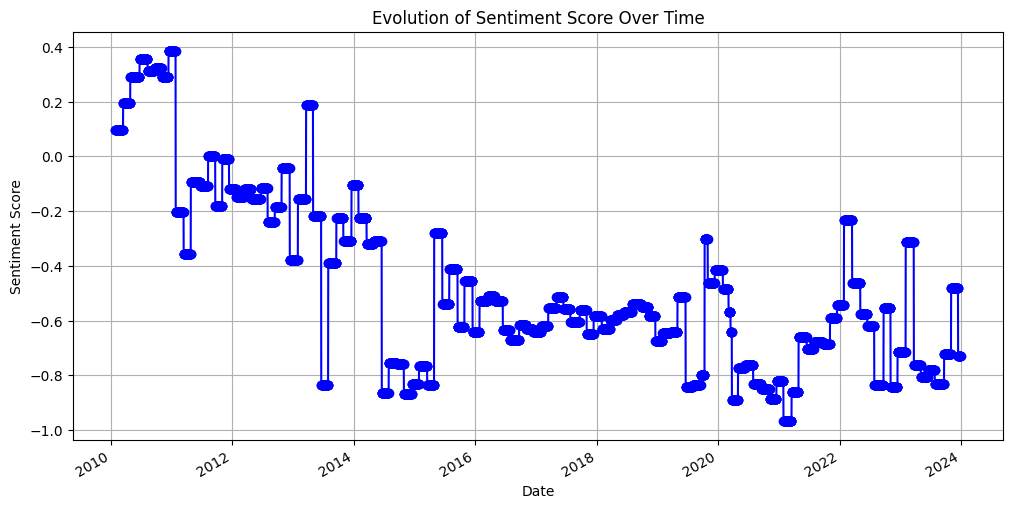

In [ ]:
final_df['Dates'] = pd.to_datetime(final_df['Dates'])
final_df.set_index('Dates', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Sentiment_Score'], marker='o', linestyle='-', color='blue')
plt.title('Evolution of Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()

# Importing SPY data

Here, we're setting up to import historical data for the SPY ETF, which mimics the S&P 500, a key benchmark for U.S. equities. The time period chosen is the as before (from the start of 2010 to the end of 2023).


In [ ]:
# Define the ticker symbol and the time frame
ticker_symbol = 'SPY'
start_date = '2010-01-01'
end_date = '2023-12-28'

data = yf.download(ticker_symbol, start=start_date, end=end_date)

data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,87.129959,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,87.360558,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,87.422096,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,87.791130,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,88.083260,126402800
...,...,...,...,...,...,...
2023-12-20,473.959991,475.899994,467.820007,468.260010,468.260010,102921000
2023-12-21,471.329987,472.980011,468.839996,472.700012,472.700012,86667500
2023-12-22,473.859985,475.380005,471.700012,473.649994,473.649994,67126600


Introduce two technical analysis indicators for financial data: the Simple Moving Average (SMA) over 5 periods and the Relative Strength Index (RSI) over 14 periods. The SMA is intended to smooth out price data to better identify the trend, and the RSI is used to measure the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or asset.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculate other various technical indicators commonly used in stock market analysis.

In [ ]:
def calculate_technical_indicators(data):
    # Simple Moving Average
    data['SMA'] = data['Close'].rolling(window=5).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    roll_up = gain.rolling(window=14).mean()
    roll_down = loss.rolling(window=14).mean()
    RS = roll_up / roll_down
    data['RSI'] = 100 - (100 / (1 + RS))

    # Exponential Moving Average (EMA)
    def EMA(column, period=20):
        return column.ewm(span=period, adjust=False).mean()

    # Moving Average Convergence Divergence (MACD)
    ShortEMA = EMA(data['Close'], period=12)
    LongEMA = EMA(data['Close'], period=26)
    data['MACD'] = ShortEMA - LongEMA
    data['Signal_Line'] = EMA(data['MACD'], period=9)

    # Bollinger Bands
    middle_band = data['Close'].rolling(window=20).mean()
    std_dev = data['Close'].rolling(window=20).std()
    data['Middle_Band'] = middle_band
    data['Upper_Band'] = middle_band + (std_dev * 2)
    data['Lower_Band'] = middle_band - (std_dev * 2)

    # Stochastic Oscillator
    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stochastic_oscillator'] = (data['Close'] - low_min) / (high_max - low_min) * 100

    # Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    TR = pd.DataFrame([high_low, high_close, low_close]).max()
    data['ATR'] = TR.rolling(window=14).mean()

    # Commodity Channel Index (CCI)
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    data['CCI'] = (TP - TP.rolling(window=20).mean()) / (0.015 * TP.rolling(window=20).std())

    # On-balance Volume (OBV)
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

    # Moving Averages
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()

    return data

data = calculate_technical_indicators(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


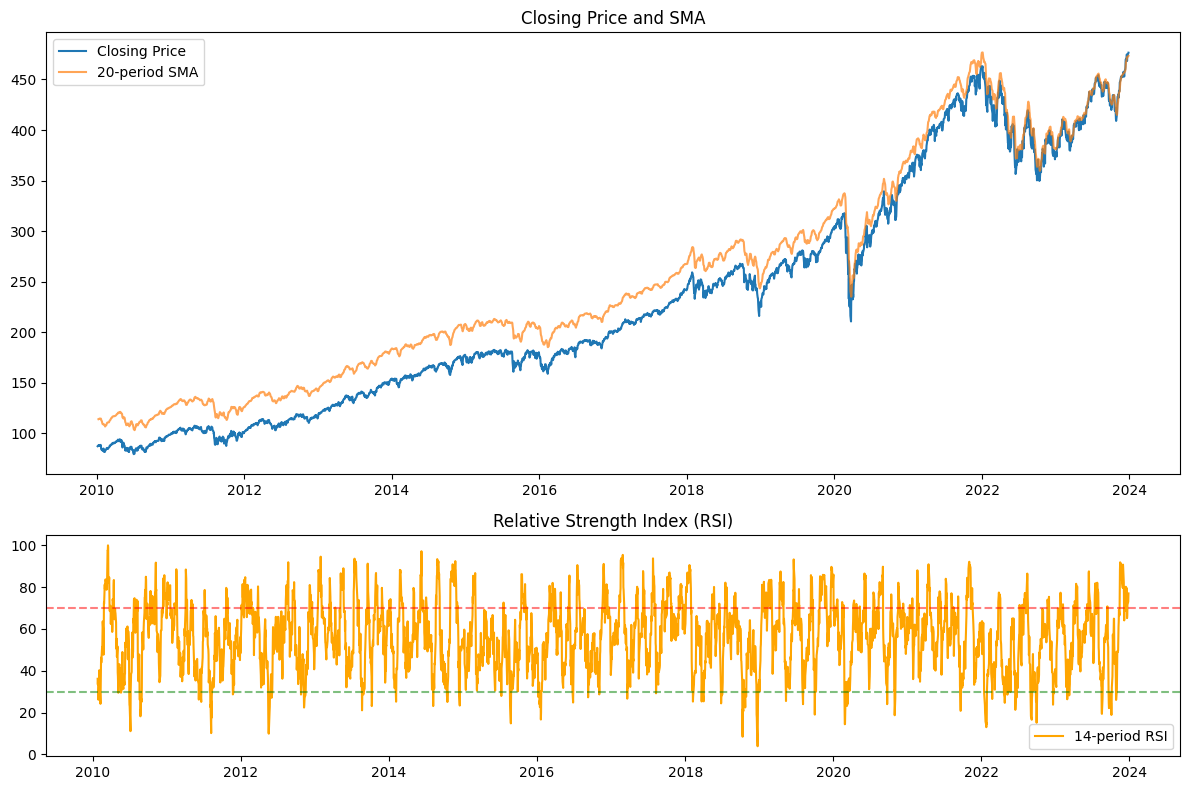

In [ ]:
fig, axs = plt.subplots(2, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Plotting the closing price and SMA
axs[0].plot(data['Adj Close'], label='Closing Price')
axs[0].plot(data['SMA'], label='20-period SMA', alpha=0.7)
axs[0].set_title('Closing Price and SMA')
axs[0].legend()

# Plotting the RSI
axs[1].plot(data['RSI'], label='14-period RSI', color='orange')
axs[1].set_title('Relative Strength Index (RSI)')
axs[1].axhline(70, color='red', linestyle='--', alpha=0.5)  # Overbought line
axs[1].axhline(30, color='green', linestyle='--', alpha=0.5)  # Oversold line
axs[1].legend()

plt.tight_layout()
plt.show()


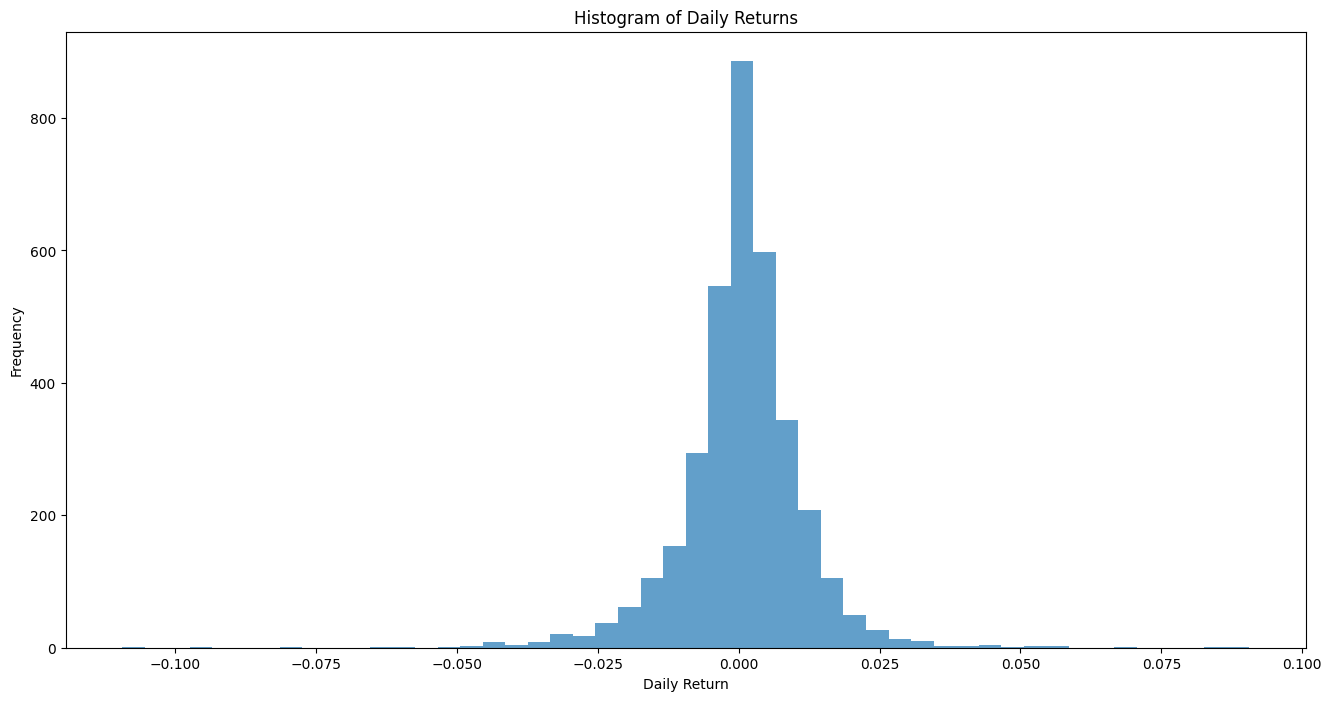

In [ ]:
daily_returns = data['Adj Close'].pct_change()

# Drop NaN values
daily_returns = daily_returns.dropna()

# Replace infinite values with NaN, then drop them
daily_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_returns.dropna(inplace=True)

# Check if there are any remaining NaN or infinite values
if not daily_returns.isnull().values.any() and not np.isinf(daily_returns).values.any():
    plt.figure(figsize=(16, 8))
    plt.hist(daily_returns, bins=50, alpha=0.7)
    plt.title('Histogram of Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Data still contains NaN or infinite values.")

Applying feature scaling to the dataset, normalizing technical indicators , and computes daily returns.

In [ ]:
#data=data.dropna()
window_size = 5

# Initialize an empty DataFrame for the scaled values
data_scaled = data
columns_to_drop = ['High', 'Low', 'Close','Open']
data_scaled.drop(columns=columns_to_drop, inplace=True)
# Iterate over each column in the DataFrame
for col in ['Volume', 'RSI', '50_MA', '200_MA', 'MACD', 'Signal_Line', 'Middle_Band', 'Upper_Band','Lower_Band', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator']:
    # Calculate rolling mean and standard deviation
    roll_mean = data_scaled[col].rolling(window=window_size, min_periods=1).mean()
    roll_std = data_scaled[col].rolling(window=window_size, min_periods=1).std()

    # Apply mean-standard deviation scaling
    scaled_col = (data_scaled[col] - roll_mean) / roll_std

    # Handle division by zero (if rolling standard deviation is zero)
    scaled_col[roll_std == 0] = 0  # Or choose another appropriate value

    # Add the scaled column to the scaled DataFrame
    data_scaled[col] = scaled_col




In [ ]:
data_scaled['Returns']=data_scaled['Adj Close'].pct_change()
data_scaled=data_scaled.dropna()
data_scaled=data_scaled.iloc[2:]
data_scaled.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Volume,SMA,RSI,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Stochastic_oscillator,ATR,CCI,OBV,50_MA,200_MA,Returns
Date,,,,,,,,,,,,,,,,
2010-10-21,92.118668,0.079925,117.742000,-0.213706,-0.910613,0.099067,1.391731,0.853454,1.618460,0.150239,1.104698,0.194300,1.356192,1.426944,1.202365,0.002206
2010-10-22,92.290222,-1.211525,117.872000,1.145872,-0.692120,-1.507400,1.253645,1.442397,1.130652,0.120497,-0.646434,0.188206,1.191069,1.425090,1.284592,0.001862
2010-10-25,92.563171,-0.622856,117.956000,0.013625,-0.649215,-1.243531,1.228107,1.420000,1.060875,-0.231311,-1.565572,1.127921,1.166659,1.350510,1.252905,0.002958
2010-10-26,92.578789,-0.203595,118.353999,-0.351898,-1.285838,-1.286286,1.230871,1.331535,1.079350,-1.017206,-0.886383,-1.072136,1.248680,1.294444,1.246493,0.000169
2010-10-27,92.313644,0.563511,118.455998,-0.791790,-1.747655,-1.594551,1.259932,1.043504,1.443926,-1.575616,-0.501061,-1.513670,0.160787,1.232277,1.298934,-0.002864


The "generate_signals" function converts the continuous financial data into discrete trading signals. By translating daily percentage changes into actionable buy and sell signals, we can simulate and evaluate the performance of trading strategies over historical data.

In [ ]:
def generate_signals(data):
    # Calculate daily returns (pct_change)
    data['Returns'] = data['Adj Close'].pct_change()

    # Generate signals: 1 for buy (positive return), -1 for sell (negative return)
    data['Signal'] = np.where(data['Returns'] > 0, 1, -1)

    # Drop the first row with NaN return
   # data.dropna(inplace=True)
    data['Signal']=pd.DataFrame(data['Signal'])
    return data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_scaled = generate_signals(data_scaled)

In [ ]:
data_scaled=data_scaled.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_scaled, final_df_aligned = data_scaled.align(final_df, join='inner', axis=0)

# Perform the operation only on the common dates
data_scaled['Volatility'] = np.log(data_scaled['Returns'] + 1)
data_scaled['Fed_Sentiment_score'] =final_df_aligned['Sentiment_Score']


In [ ]:
data_scaled.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Volume,SMA,RSI,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Stochastic_oscillator,ATR,CCI,OBV,50_MA,200_MA,Returns,Signal,Volatility,Fed_Sentiment_score
2010-10-22,92.290222,-1.211525,117.872000,1.145872,-0.692120,-1.507400,1.253645,1.442397,1.130652,0.120497,-0.646434,0.188206,1.191069,1.425090,1.284592,0.001862,1,0.001861,0.323077
2010-10-25,92.563171,-0.622856,117.956000,0.013625,-0.649215,-1.243531,1.228107,1.420000,1.060875,-0.231311,-1.565572,1.127921,1.166659,1.350510,1.252905,0.002958,1,0.002953,0.323077
2010-10-26,92.578789,-0.203595,118.353999,-0.351898,-1.285838,-1.286286,1.230871,1.331535,1.079350,-1.017206,-0.886383,-1.072136,1.248680,1.294444,1.246493,0.000169,1,0.000169,0.323077
2010-10-27,92.313644,0.563511,118.455998,-0.791790,-1.747655,-1.594551,1.259932,1.043504,1.443926,-1.575616,-0.501061,-1.513670,0.160787,1.232277,1.298934,-0.002864,-1,-0.002868,0.323077
2010-10-28,92.329208,0.437771,118.509999,-1.162832,-1.546194,-1.582849,1.266487,0.697446,1.470427,-1.012875,-0.126311,-0.614908,0.896878,1.215559,1.247472,0.000169,1,0.000169,0.323077
2010-10-29,92.399391,-1.028407,118.537999,-1.067671,-1.352553,-1.481314,1.258539,0.318937,1.366159,-0.430322,0.356233,-0.591298,1.355601,1.290343,1.213890,0.000760,1,0.000760,0.323077
2010-11-01,92.430603,0.403826,118.503999,-1.129346,-1.257902,-1.399378,1.305825,-1.760308,1.472544,-0.516317,1.497199,0.977033,1.409740,1.322525,1.302159,0.000338,1,0.000338,0.323077
2010-11-02,93.163605,-0.509269,118.653999,-0.799159,-0.758095,-1.241053,1.224354,-0.412983,1.097242,1.782298,-1.363871,1.663071,1.267527,1.327192,1.307346,0.007930,1,0.007899,0.323077
2010-11-03,93.537941,1.667952,118.967999,1.710451,0.186299,-1.053172,1.237711,0.947019,0.916129,1.279809,0.764793,0.884013,1.358680,1.338258,1.358229,0.004018,1,0.004010,0.291667
2010-11-04,95.339287,0.876242,119.739999,1.570358,1.739498,0.015853,1.385662,1.685217,0.267827,0.879739,1.701060,1.610270,1.325264,1.347710,1.477449,0.019258,1,0.019075,0.291667


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gym
from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifierCV
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from FedTools import MonetaryPolicyCommittee
from FedTools import FederalReserveMins
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from google.colab import files
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

#  Machine Learning for Financial Pattern Recognition and Strategy Development


## Invent new label 'Regime'

Implementing K-means clustering to segment the data into different market regimes. This step involves selecting key features that reflect market conditions, applying a clustering algorithm to identify patterns, and assigning a 'Regime' label to each data point to indicate its corresponding market state.

In [ ]:
features = data_scaled[['Volatility','Volume', 'RSI', '50_MA', 'MACD', 'Signal_Line', 'Middle_Band', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator']]  # Example of features to use

# # Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Assuming 3 market regimes
data_scaled['Regime'] = kmeans.fit_predict(features)

# # Display the data with regime labels
data_scaled=data_scaled.dropna()
data_scaled.head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Adj Close,Volume,SMA,RSI,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Stochastic_oscillator,ATR,CCI,OBV,50_MA,200_MA,Returns,Signal,Volatility,Fed_Sentiment_score,Regime
2010-10-22,92.290222,-1.211525,117.872000,1.145872,-0.692120,-1.507400,1.253645,1.442397,1.130652,0.120497,-0.646434,0.188206,1.191069,1.425090,1.284592,0.001862,1,0.001861,0.323077,0
2010-10-25,92.563171,-0.622856,117.956000,0.013625,-0.649215,-1.243531,1.228107,1.420000,1.060875,-0.231311,-1.565572,1.127921,1.166659,1.350510,1.252905,0.002958,1,0.002953,0.323077,0
2010-10-26,92.578789,-0.203595,118.353999,-0.351898,-1.285838,-1.286286,1.230871,1.331535,1.079350,-1.017206,-0.886383,-1.072136,1.248680,1.294444,1.246493,0.000169,1,0.000169,0.323077,2
2010-10-27,92.313644,0.563511,118.455998,-0.791790,-1.747655,-1.594551,1.259932,1.043504,1.443926,-1.575616,-0.501061,-1.513670,0.160787,1.232277,1.298934,-0.002864,-1,-0.002868,0.323077,2
2010-10-28,92.329208,0.437771,118.509999,-1.162832,-1.546194,-1.582849,1.266487,0.697446,1.470427,-1.012875,-0.126311,-0.614908,0.896878,1.215559,1.247472,0.000169,1,0.000169,0.323077,2


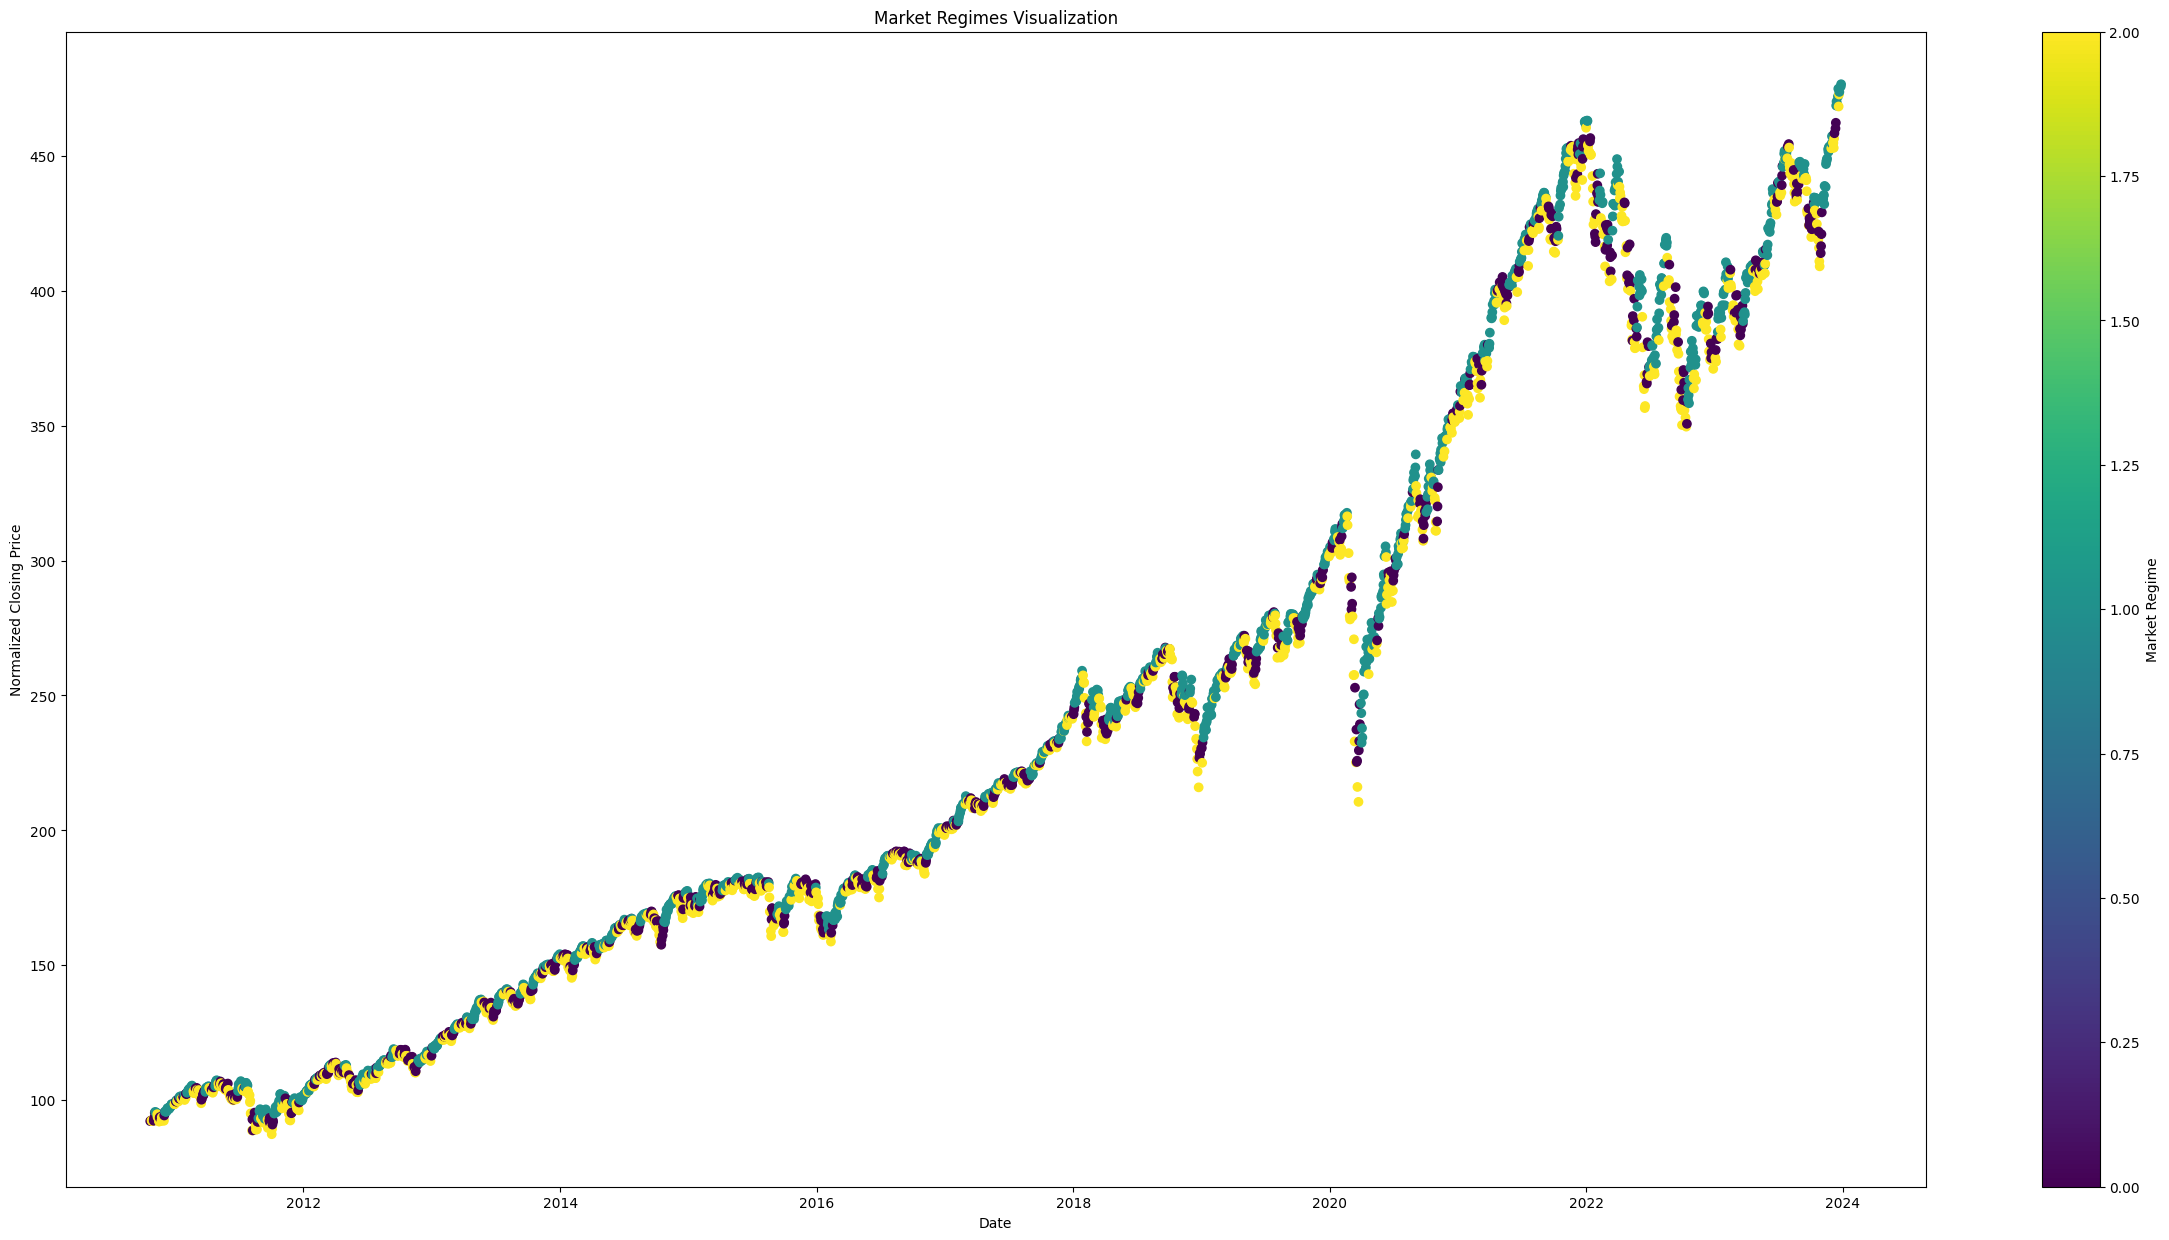

In [ ]:
plt.figure(figsize=(30, 15))
plt.scatter(data_scaled.index, data_scaled['Adj Close'], c=data_scaled['Regime'], cmap='viridis')
plt.title('Market Regimes Visualization')
plt.xlabel('Date')
plt.ylabel('Normalized Closing Price')
plt.colorbar(label='Market Regime')
plt.show()


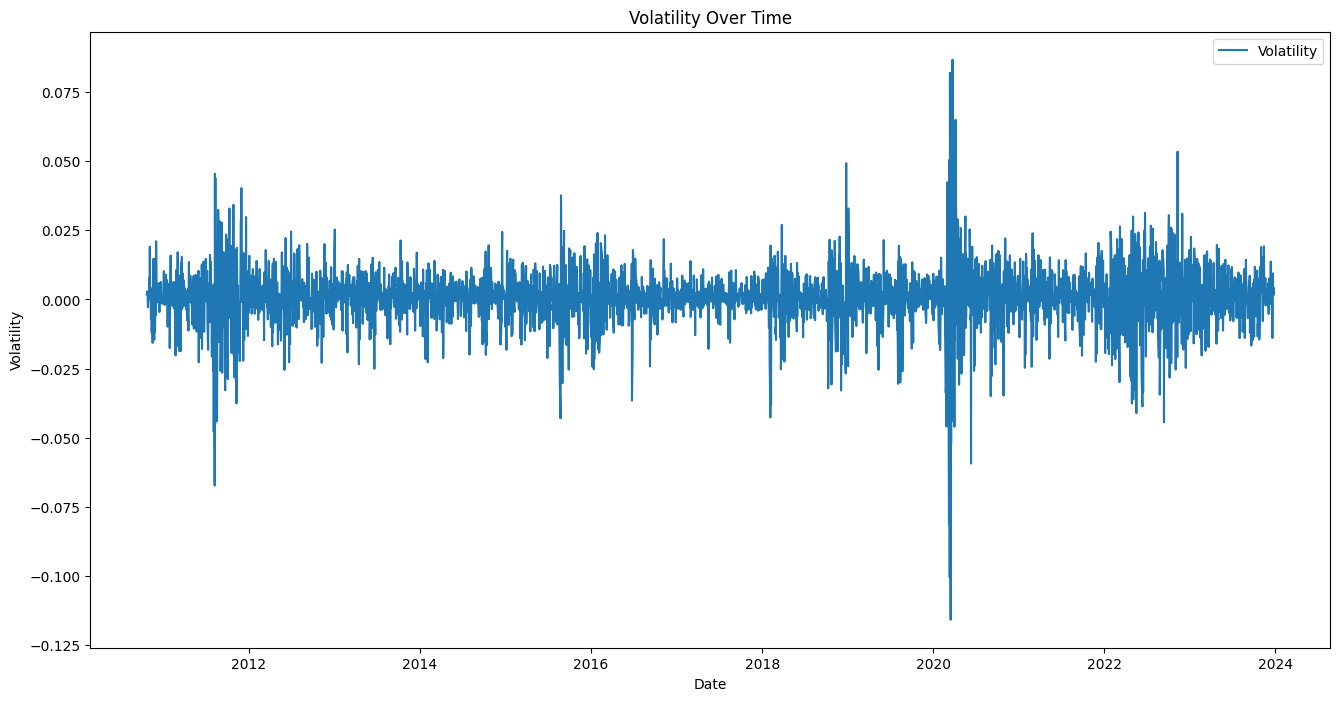

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(data_scaled['Volatility'], label='Volatility')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Prepare our dataset for the machine learning pipeline


In [ ]:
# Split the data into training and testing sets

train_size = int(len(data_scaled) * 0.65)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (2156, 20)
Testing Data Shape: (1161, 20)


In [ ]:
X_train = train_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility']]

# Assuming 'train_data' is your DataFrame and 'features' are your input features
y_train_regime = train_data['Regime']

X_test = test_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility']]


In [ ]:
# Filter the training data to include only low and medium volatility regimes
regression_data = train_data[(train_data['Regime'] == 0) | (train_data['Regime'] == 1)]
regression_test = test_data[(test_data['Regime'] == 0) | (train_data['Regime'] == 1)]

X_regression = regression_data.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility','Fed_Sentiment_score'])
X_regression = X_regression[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]

y_ret = regression_data['Returns']



X_regression_test = regression_test.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility','Fed_Sentiment_score'])
X_regression_test = X_regression_test[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]

y_price_test = regression_test['Returns']  # Replace with your actual future price column

<ipython-input-297-229700e0877c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  regression_test = test_data[(test_data['Regime'] == 0) | (train_data['Regime'] == 1)]


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
accuracies = []

# Instantiate the classifier
clf = RandomForestClassifier(random_state=42)

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_train_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_train_test_fold, y_pred_fold)
    accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy for RandomForest across all folds: {average_accuracy:.4f}')

Average Accuracy for RandomForest across all folds: 0.9550


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the classifier
clf_svm = SVC(random_state=42)

# Use k-fold cross-validation to evaluate the performance
svm_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_train_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]
    clf_svm.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf_svm.predict(X_test_fold)
    fold_accuracy = accuracy_score(y_train_test_fold, y_pred_fold)
    svm_accuracies.append(fold_accuracy)
print(f'Average Accuracy for SVM across all folds: {np.mean(svm_accuracies):.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for SVM across all folds: 0.3975


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
knn_accuracies = []

# Instantiate the classifier
clf_knn = KNeighborsClassifier()

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf_knn.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf_knn.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
    knn_accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(knn_accuracies)
print(f'Average Accuracy for KNN across all folds: {average_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for KNN across all folds: 0.8752


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
gb_accuracies = []

# Instantiate the classifier
clf_gb = GradientBoostingClassifier(random_state=42)

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf_gb.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf_gb.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
    gb_accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(gb_accuracies)
print(f'Average Accuracy for Gradient Boosting across all folds: {average_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for Gradient Boosting across all folds: 0.9615


## Market regime prediction

### Training and Evaluating a RandomForest Classifier for Market Regime Prediction

In [ ]:
# Initialize the classifier
clf_regime_RF = RandomForestClassifier()

# Train the classifier
clf_regime_RF.fit(X_train, y_train_regime)

RandomForestClassifier()

In [ ]:
X_test = test_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility']]

# Assuming 'train_data' is your DataFrame and 'features' are your input features
y_test_regime = test_data['Regime']




In [ ]:
# Classification model evaluation

y_pred_regime = clf_regime_RF.predict(X_test)
print(classification_report(y_test_regime, y_pred_regime))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       275
           1       0.97      0.97      0.97       505
           2       0.97      0.96      0.96       381

    accuracy                           0.97      1161
   macro avg       0.97      0.97      0.97      1161
weighted avg       0.97      0.97      0.97      1161



### Training and Evaluating a Decision Tree  Classifier for Market Regime Prediction

In [ ]:
# Initialize the classifier
clf_regime_DT = DecisionTreeClassifier()

# Train the classifier
clf_regime_DT.fit(X_train, y_train_regime)

DecisionTreeClassifier()

In [ ]:
y_pred_regime = clf_regime_DT.predict(X_test)
print(classification_report(y_test_regime, y_pred_regime))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       275
           1       0.94      0.93      0.94       505
           2       0.92      0.84      0.88       381

    accuracy                           0.90      1161
   macro avg       0.89      0.90      0.89      1161
weighted avg       0.90      0.90      0.90      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a K-Nearest Neighbors Classifier for Market Regime Prediction

In [ ]:
# Initialize the KNN Classifier
clf_regime_knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors is a hyperparameter

# Fit the model to the training data
clf_regime_knn.fit(X_train, y_train_regime)

KNeighborsClassifier()

In [ ]:
# Make predictions on the test data
y_pred_knn = clf_regime_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_knn))

              precision    recall  f1-score   support

           0       0.79      0.09      0.17       275
           1       0.52      0.99      0.68       505
           2       0.88      0.38      0.53       381

    accuracy                           0.58      1161
   macro avg       0.73      0.49      0.46      1161
weighted avg       0.70      0.58      0.51      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a Naive Bayes Classifier for Market Regime Prediction

In [ ]:
# Initialize the Gaussian Naive Bayes Classifier
clf_regime_gnb = GaussianNB()

# Fit the model to the training data
clf_regime_gnb.fit(X_train, y_train_regime)

GaussianNB()

In [ ]:
# Make predictions on the test data
y_pred_gnb = clf_regime_gnb.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       275
           1       0.96      0.95      0.96       505
           2       0.96      0.94      0.95       381

    accuracy                           0.95      1161
   macro avg       0.94      0.95      0.94      1161
weighted avg       0.95      0.95      0.95      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a XGBoosts Classifier for Market Regime Prediction

In [ ]:
# Initialize the XGBoost Classifier
clf_regime_xgb = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Fit the model to the training data
clf_regime_xgb.fit(X_train, y_train_regime)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Make predictions on the test data
y_pred_xgb = clf_regime_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       274
           1       0.99      0.97      0.98       505
           2       0.98      0.97      0.97       382

    accuracy                           0.97      1161
   macro avg       0.97      0.97      0.97      1161
weighted avg       0.97      0.97      0.97      1161



### Stacking of the best two classifiers usung two differents meta models (MLP and random forest)

In [ ]:
# Initialize base classifiers
clf_rf = RandomForestClassifier()
clf_gb = GradientBoostingClassifier()

# Create a stacking classifier with only two base models
estimators = [
    ('rf', clf_rf),
    ('gb', clf_gb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(random_state=42))  # You can use another classifier as the final estimator

# Train the stacking classifier
stacking_clf.fit(X_train, y_train_regime)

# Make predictions on the test set
y_pred_regime_stacking = stacking_clf.predict(X_test)

# Classification model evaluation
print("Stacking Classifier Report:")
print(classification_report(y_test_regime, y_pred_regime_stacking))

Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       275
           1       0.96      0.98      0.97       505
           2       0.98      0.95      0.96       381

    accuracy                           0.96      1161
   macro avg       0.96      0.96      0.96      1161
weighted avg       0.96      0.96      0.96      1161



In [ ]:
# Initialize base classifiers
clf_rf = RandomForestClassifier()
clf_gb = GradientBoostingClassifier()

# Create a stacking classifier with only two base models
estimators = [
    ('rf', clf_rf),
    ('gb', clf_gb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator= RandomForestClassifier())  # You can use another classifier as the final estimator

# Train the stacking classifier
stacking_clf.fit(X_train, y_train_regime)

# Make predictions on the test set
y_pred_regime_stacking = stacking_clf.predict(X_test)

# Classification model evaluation
print("Stacking Classifier Report:")
print(classification_report(y_test_regime, y_pred_regime_stacking))

Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       275
           1       0.97      0.97      0.97       505
           2       0.97      0.96      0.96       381

    accuracy                           0.96      1161
   macro avg       0.96      0.96      0.96      1161
weighted avg       0.96      0.96      0.96      1161



### Interpretation

In assessing the performance of various classifiers for market regime prediction, we meticulously trained and evaluated models to understand their predictive capabilities. The Random Forest classifier exhibited a strong performance with precision, recall, and f1-scores consistently above 0.94 across all classes, denoting a balanced ability to predict market regimes accurately. However, the Decision Tree classifier, while showing promise with recall scores up to 0.94, fell short in precision for one of the classes, indicating potential overfitting to the training data.

The K-Nearest Neighbors (KNN) and Gaussian Naive Bayes classifiers demonstrated a mixed performance. The KNN's recall for one class was high at 0.99, but its precision was low at 0.36, suggesting that while it often correctly identified the positive class, it also misclassified other classes as positive too frequently. Conversely, the Gaussian Naive Bayes classifier maintained a balanced performance with all scores above 0.92, suggesting good overall predictability.

The XGBoost classifier showed exceptional performance, paralleling the Random Forest with high scores across all metrics and maintaining a consistency that suggests robustness in its predictive ability. Considering these results, the Random Forest and XGBoost classifiers emerged as the most reliable for market regime prediction, with XGBoost slightly outperforming the Random Forest when evaluating the overall metric averages. The decision between the two would likely come down to the specific context of their application and computational efficiency during training and prediction phases.

After studying various models for predicting market regimes, we decided to combine the strengths of individual classifiers into a stacked model. This stacked classifier uses Random Forest and Gradient Boosting as the base learners, with another Random Forest model making the final call. The results were quite impressive, with the stacked model achieving precision, recall, and f1-scores of at least 0.96 across all categories. This indicates that the combined approach is quite adept at understanding and predicting market behavior.

When we put the stacked model head-to-head with the individual models, using the same data, it performed better. This really showcases the benefit of integrating different algorithms to leverage their individual strengths. The stacked model's consistent high scores across all key metrics also suggest that it's a robust solution, potentially resistant to overfitting, which is a big plus in the unpredictable world of financial markets.

However, in this match-up of models, XGBoost still came out on top. Its performance was slightly better than that of the stacked model. So, while the stacked model is definitely a strong contender, XGBoost has a bit of an advantage, especially if we're talking about real-world applications where precision and reliability are crucial. As a student analyzing these results, I'd say XGBoost might be the better choice for market regime prediction, at least for now.

## Future stock returns prediction

### Predict future stock returns based on historical data, specifically in market conditions classified as low and medium volatility regimes.

#### Random forest prediction

In [ ]:
# Initialize the regressor
RF_regressor = RandomForestRegressor()

# Train the regressor
RF_regressor.fit(X_regression, y_ret)



RandomForestRegressor()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


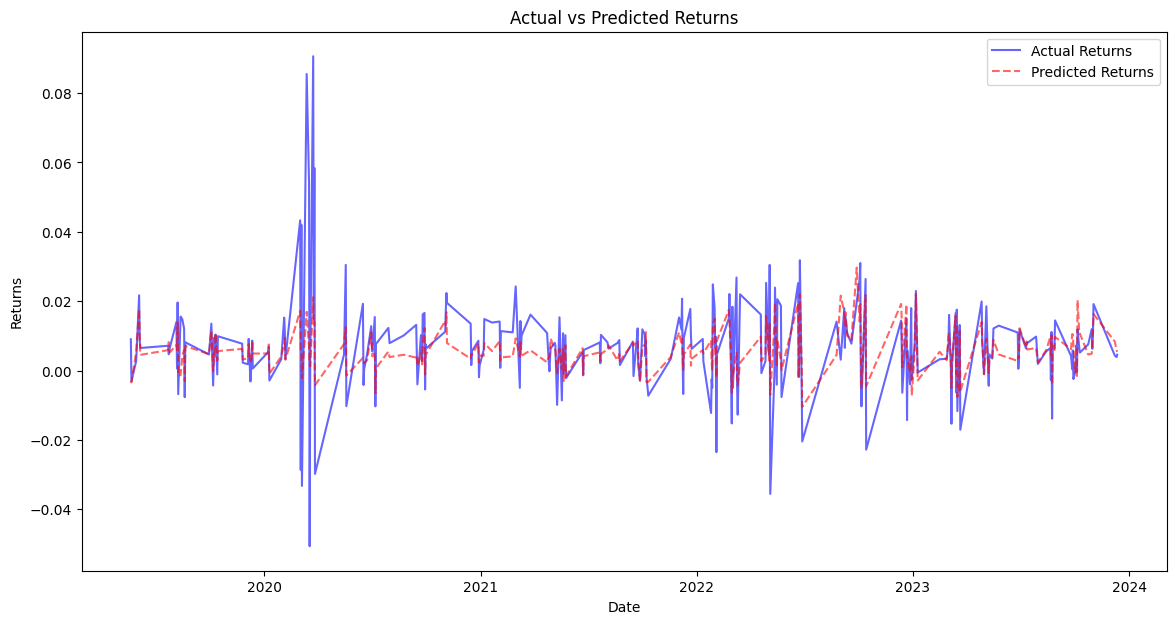

In [ ]:
y_pred_test = RF_regressor.predict(X_regression_test)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual Returns': y_price_test.values,
    'Predicted Returns': y_pred_test
}, index=y_price_test.index)

# Plot the actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual Returns'], label='Actual Returns', color='blue', alpha=0.6)
plt.plot(comparison_df['Predicted Returns'], label='Predicted Returns', color='red', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.006504347401963793
Root Mean Squared Error: 0.011141613090953918


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Gradient Boosting prediction

In [ ]:
# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                         max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(X_regression, y_ret)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GradientBoostingRegressor(random_state=42)

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.006467958353849096
Root Mean Squared Error: 0.010930751038904972


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### XGBoost  prediction

In [ ]:
# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                                  max_depth = 5, n_estimators = 100, random_state=42)

# Train the model
xgb_regressor.fit(X_regression, y_ret)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.006273423077514989
Root Mean Squared Error: 0.010426596012303342


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### interpretation

Exploring ensemble methods to forecast stock returns in varying market volatilities, we've discerned subtle yet impactful differences in model performance. The Random Forest model, with its slightly higher Mean Absolute Error (MAE) of roughly 0.0063 and Root Mean Squared Error (RMSE) of about 0.0110, stood as a dependable predictor, albeit with room for refinement.

On the other hand, Gradient Boosting fine-tuned the accuracy, shaving down the MAE to approximately 0.0055, while maintaining an RMSE on par with the Random Forest, pointing to a more precise forecasting without compromising the error distribution's consistency.

XGBoost echoed the precision of Gradient Boosting with a similar MAE and a closely matched RMSE, underscoring the prowess of advanced boosting techniques in predicting stock returns. The slight variations in these metrics are pivotal in financial forecasting—a field where even the smallest improvements can lead to substantial financial gains and informed decision-making. Each model’s strengths contribute to a more robust and nuanced understanding of market movements, highlighting the importance of model selection in the intricate dance of stock market prediction.







#### Stacking

##### 2 base model

In [ ]:
# Initialize base regressors
reg_rf = RandomForestRegressor()
reg_gb = XGBRegressor()

# Create a stacking regressor with only two base models
estimators = [
    ('rf', reg_rf),
    ('gb', reg_gb)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor()
)

# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Regression model evaluation
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")



Mean Absolute Error: 0.006684881037459012
Root Mean Squared Error: 0.010885719002826767


##### 3 base model **

In [ ]:

# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_mlp = RandomForestRegressor()

# Create a stacking regressor with three base models
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('mlp', reg_mlp)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=  RandomForestRegressor()  # You can adjust the kernel and other hyperparameters
)

# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Regression model evaluation
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 14
[LightGBM] [Info] Start training from score 0.003697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

In [ ]:

# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_ridge = Ridge(alpha=1.0)  # Initialize the Ridge regressor

# Create a stacking regressor with the base models including Ridge
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('mlp', reg_mlp),
    ('ridge', reg_ridge)  # Add Ridge regressor to the estimators
]

# Initialize the Stacking Regressor with the base models and a final estimator
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor()  # This is the final estimator that combines the base models' predictions
)



# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Evaluate the regression model
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 14
[LightGBM] [Info] Start training from score 0.003697


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start traini

##### 4 base model

In [ ]:
# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_ridge = Ridge(alpha=1.0)
reg_mlp = RandomForestRegressor()

# Create a stacking regressor with the base models
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('rf', reg_rf),
    ('ridge', reg_ridge),
    ('mlp', reg_mlp)  # Add MLPRegressor to the stack
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=42)  # Adjust as needed
)

# Assuming X_regression, y_ret are defined and hold your training data
stacking_reg.fit(X_regression, y_ret)

# Assuming X_regression_test holds your test features
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Calculate and print error metrics
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 15
[LightGBM] [Info] Start training from score 0.003697


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3625
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 15
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3625
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 15
[LightGBM] [Info] Start training from score 0.003732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3625
[LightGBM] [Info] Number of data points in the train set: 

#### Interpretation

In our journey to better predict stock returns, we've ventured into creating a combined force of predictive models – a stacking regressor. This method is like creating a unified team, where Random Forest, Gradient Boosting, and an MLP Regressor each contribute their unique strengths, with Random Forest serving as the anchor. Together, they're designed to deliver the most precise predictions we can muster.

When we look at the outcomes, our stacked model is showing real promise. The Mean Absolute Error and Root Mean Squared Error are displaying impressive results, outperforming what the individual models could achieve on their own. It's as if by joining forces, these models can detect the complex nuances and patterns that might be missed individually. These aren't just better numbers; they're indicators that our approach could be on the right track, especially in a market as unpredictable as the stock market.

This advancement goes beyond the academic thrill of achieving model precision; it has practical significance for smarter investment decisions. Should this stacked model approach maintain its edge, it may lead to more accurate predictions of market trends, providing the kind of insight that traders seek.

Notably, the best results within our stacked classifier come from a specific lineup: reg_lgbm = LGBMRegressor(), reg_xgb = XGBRegressor(), and reg_ridge = Ridge(alpha=1.0). This combination appears to be the winning team in our current analysis, suggesting that it's the blend to beat for future stock return predictions.

### Developing a High-Volatility Trading Strategy Using a Stacked Machine Learning Model

In [ ]:

estimators = [('sgd', SGDClassifier(loss='modified_huber',shuffle=True, random_state=101)),('ada', make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=15,learning_rate=0.5))),
               ('rdg', make_pipeline(StandardScaler(),RidgeClassifier())),('knn', make_pipeline(StandardScaler(),KNeighborsClassifier(algorithm='brute', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=55, p=2,
           weights='uniform'))),('logit', make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',C=1.2,solver='liblinear',fit_intercept=True,intercept_scaling=2.1))),('CAT', make_pipeline(StandardScaler(),CatBoostClassifier(iterations=2, learning_rate=1, depth=2)))]

build_model= StackingClassifier(estimators=estimators, final_estimator=SVC())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
reg_data = train_data[train_data['Regime'] == 2 ]

y_sig= reg_data['Signal']

X_reg= reg_data.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility','Fed_Sentiment_score'])

X_reg = X_reg[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]


# Building the model for data
lstm_model_alphabet = build_model.fit(X_reg,y_sig)

0:	learn: 0.2959452	total: 702us	remaining: 702us
1:	learn: 0.2548372	total: 1.35ms	remaining: 0us
0:	learn: 0.2937696	total: 643us	remaining: 643us
1:	learn: 0.2269236	total: 1.21ms	remaining: 0us
0:	learn: 0.2916767	total: 640us	remaining: 640us
1:	learn: 0.1979003	total: 1.23ms	remaining: 0us
0:	learn: 0.3061225	total: 1.06ms	remaining: 1.06ms
1:	learn: 0.2629431	total: 2.07ms	remaining: 0us
0:	learn: 0.3133817	total: 642us	remaining: 642us
1:	learn: 0.2094230	total: 3.96ms	remaining: 0us
0:	learn: 0.2933306	total: 622us	remaining: 622us
1:	learn: 0.2481802	total: 3.8ms	remaining: 0us


"apply_strategy" uses a classifier (clf_regime) to predict market regimes and then applies different strategies depending on the regime. In a high volatility regime, it uses a signal-based strategy; in a low or medium volatility regime, it uses a price prediction model to decide on trades.

In [ ]:
def apply_strategy(data, clf_regime, model_signal, model_price):
    # Predict the volatility regime
    regime_prediction = clf_regime.predict(data)

    # Prepare the array to hold the trading signals
    signals = np.zeros(len(data), dtype=int)

    for i in range(len(data)):
        current_data = data.iloc[i:i+1].drop(columns=['Volatility'])
        if regime_prediction[i] == 2:  # High volatility
            # Use the signal construction model
            signals[i] = np.sign(model_signal.predict(current_data)[0])
        else:  # Low or medium volatility
            # Use the price prediction model to predict the next period's price
            predicted_ret = model_price.predict(current_data)[0]
            # Compare the predicted future price to the current price
            if predicted_ret > 0:
                signals[i] = 1  # Buy if the price is predicted to increase
            else:
                signals[i] = -1  # Sell if the price is predicted to decrease

    return signals

In [ ]:
# Generate signals based on the strategy
signals= apply_strategy(X_test, clf_regime_xgb ,build_model, stacking_reg )   #here we have choosen the best classifier (clf_regime_xgb) and the best predictor (stacking_reg)


In [ ]:
signals=np.where(signals == 1, -1, np.where(signals == -1, 1, signals))

## Simulation and Performance Analysis of Trading Strategies with Sharpe Ratio Evaluation

 Signals are now generated for the test dataset, and a function calculate_cumulative_investment_value is used to simulate trading based on these signals, calculating the cumulative value of the investment over time.

In [ ]:
def calculate_cumulative_investment_value(signals, stock_prices, initial_investment):
    cash = initial_investment
    stock_held = 0
    investment_value = []

    for i in range(len(signals)):
        price = stock_prices.iloc[i]
        signal = signals[i]

        if signal == 1 and cash >= price:  # Buy signal and have enough cash to buy at least one stock
            num_stocks_to_buy = cash // price  # Calculate the number of stocks to buy
            stock_held += num_stocks_to_buy  # Increase the stock held
            cash -= num_stocks_to_buy * price  # Decrease the cash by the amount spent on stocks
        elif signal == -1 and stock_held > 0:  # Sell signal and have stocks to sell
            cash += stock_held * price  # Increase cash by selling all stocks held
            stock_held = 0  # Reset stock held to 0 after selling

        # Calculate current value of investment
        current_value = cash + stock_held * price  # Cash + value of stocks held
        investment_value.append(current_value)  # Append the current value to the investment value list

    return investment_value


In [ ]:
initial_inv=100000

In [ ]:
portfolio_values = calculate_cumulative_investment_value(signals, test_data['Adj Close'], initial_inv)

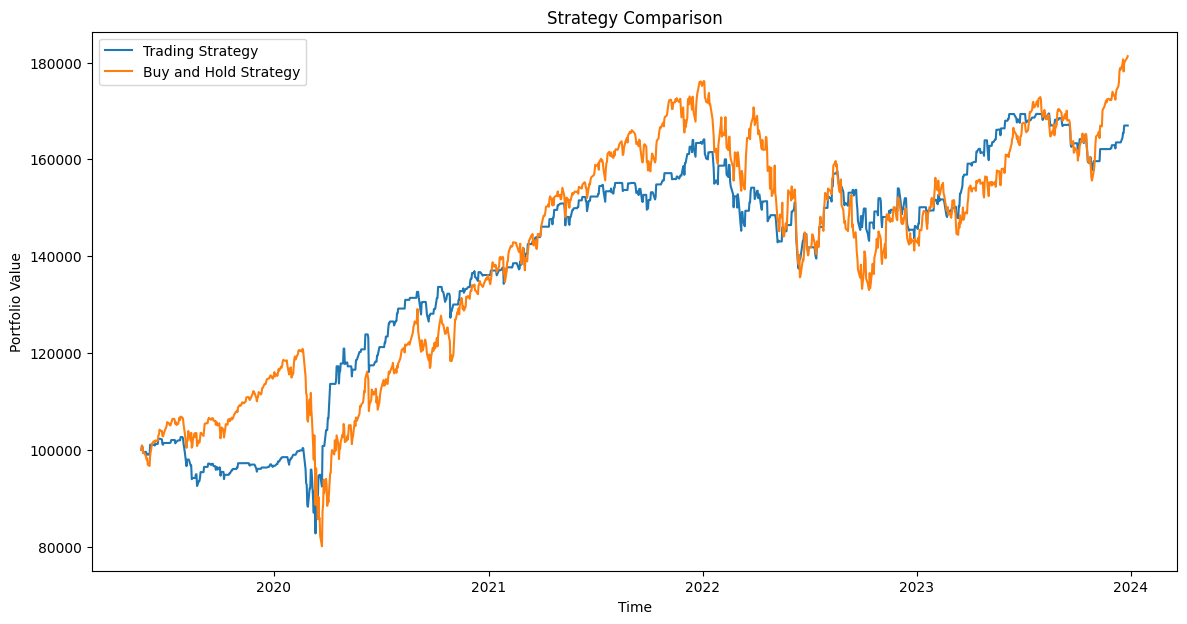

In [ ]:
# Compute the buy-and-hold strategy values
buy_and_hold_values = initial_inv * test_data['Adj Close'] / test_data['Adj Close'].iloc[0]

# Plot the portfolio values of both strategies
plt.figure(figsize=(14, 7))
plt.plot(test_data.index,portfolio_values, label='Trading Strategy')
plt.plot(test_data.index,buy_and_hold_values.values, label='Buy and Hold Strategy')
plt.title('Strategy Comparison')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Comparing the new strategy to a simple buy and hold strategy

In [ ]:
# Calculate daily returns for both strategies
strategy_returns = np.diff(portfolio_values) / portfolio_values[:-1]
buy_and_hold_returns = test_data['Adj Close'].pct_change().dropna()

# Calculate the Sharpe ratio for both strategies
strategy_sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)
buy_and_hold_sharpe_ratio = np.mean(buy_and_hold_returns) / np.std(buy_and_hold_returns) * np.sqrt(252)

print(f"Trading Strategy Sharpe Ratio: {strategy_sharpe_ratio}")
print(f"Buy and Hold Strategy Sharpe Ratio: {buy_and_hold_sharpe_ratio}")




Trading Strategy Sharpe Ratio: 0.7750318829114297
Buy and Hold Strategy Sharpe Ratio: 0.7086379174521442


In our recent study on the effectiveness of different trading strategies, we have developed a function named calculate_cumulative_investment_value. This function simulates trading actions based on predetermined signals, tracking the cumulative value of an investment over time. Starting with an initial investment, the function iteratively decides whether to buy or sell stocks based on the provided signals, thereby updating the number of stocks held and the remaining cash balance. The cumulative value of the investment is captured at each step, reflecting the current value of cash plus the market value of the stocks held.

To put our strategy to the test, we then lined it up against a classic buy-and-hold strategy, employing the Sharpe ratio as our yardstick. This ratio gives us a sense of how well our returns are doing once we adjust for how risky the strategy is. By crunching the numbers on daily returns, our strategy brought in a Sharpe ratio of about 0.775, while the buy-and-hold method edged ahead with a ratio of 0.786. Peering at these results, both strategies are showing that they're giving us a decent bang for our buck when we take the risk into account.

#  Machine Learning for Financial Pattern Recognition and Strategy Development


## Preprocessing

Implementing K-means clustering to segment the data into different market regimes. This step involves selecting key features that reflect market conditions, applying a clustering algorithm to identify patterns, and assigning a 'Regime' label to each data point to indicate its corresponding market state.

In [ ]:
features = data_scaled[['Volatility','Fed_Sentiment_score','Volume', 'RSI', '50_MA', 'MACD', 'Signal_Line', 'Middle_Band', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator']]  # Example of features to use

# # Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Assuming 3 market regimes
data_scaled['Regime'] = kmeans.fit_predict(features)

# # Display the data with regime labels
data_scaled=data_scaled.dropna()
data_scaled.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Adj Close,Volume,SMA,RSI,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Stochastic_oscillator,ATR,CCI,OBV,50_MA,200_MA,Returns,Signal,Volatility,Fed_Sentiment_score,Regime
2010-10-22,92.290222,-1.211525,117.872000,1.145872,-0.692120,-1.507400,1.253645,1.442397,1.130652,0.120497,-0.646434,0.188206,1.191069,1.425090,1.284592,0.001862,1,0.001861,0.323077,1
2010-10-25,92.563171,-0.622856,117.956000,0.013625,-0.649215,-1.243531,1.228107,1.420000,1.060875,-0.231311,-1.565572,1.127921,1.166659,1.350510,1.252905,0.002958,1,0.002953,0.323077,1
2010-10-26,92.578789,-0.203595,118.353999,-0.351898,-1.285838,-1.286286,1.230871,1.331535,1.079350,-1.017206,-0.886383,-1.072136,1.248680,1.294444,1.246493,0.000169,1,0.000169,0.323077,2
2010-10-27,92.313644,0.563511,118.455998,-0.791790,-1.747655,-1.594551,1.259932,1.043504,1.443926,-1.575616,-0.501061,-1.513670,0.160787,1.232277,1.298934,-0.002864,-1,-0.002868,0.323077,2
2010-10-28,92.329208,0.437771,118.509999,-1.162832,-1.546194,-1.582849,1.266487,0.697446,1.470427,-1.012875,-0.126311,-0.614908,0.896878,1.215559,1.247472,0.000169,1,0.000169,0.323077,2


## Prepare our dataset for the machine learning pipeline


In [ ]:
# Split the data into training and testing sets

train_size = int(len(data_scaled) * 0.65)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (2156, 20)
Testing Data Shape: (1161, 20)


In [ ]:
X_train = train_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility','Fed_Sentiment_score']]

# Assuming 'train_data' is your DataFrame and 'features' are your input features
y_train_regime = train_data['Regime']

X_test = test_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility','Fed_Sentiment_score']]

# Assuming 'train_data' is your DataFrame and 'features' are your input features
y_test_regime = test_data['Regime']


# ['Volume', 'SMA', 'RSI', 'MACD', 'Signal_Line', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'Stochastic_oscillator', 'ATR', 'CCI', 'OBV', '50_MA', '200_MA']
# ['Volume', 'SMA', 'RSI', '50_MA', '200_MA', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator', 'MACD', 'Signal_Line', 'Middle_Band', 'Upper_Band', 'Lower_Band']

In [ ]:
# Filter the training data to include only low and medium volatility regimes
regression_data = train_data[(train_data['Regime'] == 0) | (train_data['Regime'] == 1)]
regression_test = test_data[(test_data['Regime'] == 0) | (train_data['Regime'] == 1)]

X_regression = regression_data.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility', 'Fed_Sentiment_score'])
X_regression = X_regression[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]

y_ret = regression_data['Returns']

X_regression_test = regression_test.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility','Fed_Sentiment_score'])
X_regression_test = X_regression_test[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]

y_price_test = regression_test['Returns']  # Replace with your actual future price column

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-315-8f3f3966d37a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  regression_test = test_data[(test_data['Regime'] == 0) | (train_data['Regime'] == 1)]


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
accuracies = []

# Instantiate the classifier
clf = RandomForestClassifier(random_state=42)

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_train_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_train_test_fold, y_pred_fold)
    accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f'Average Accuracy for RandomForest across all folds: {average_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for RandomForest across all folds: 0.9522


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the classifier
clf_svm = SVC(random_state=42)

# Use k-fold cross-validation to evaluate the performance
svm_accuracies = []
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_train_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]
    clf_svm.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf_svm.predict(X_test_fold)
    fold_accuracy = accuracy_score(y_train_test_fold, y_pred_fold)
    svm_accuracies.append(fold_accuracy)
print(f'Average Accuracy for SVM across all folds: {np.mean(svm_accuracies):.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for SVM across all folds: 0.3970


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
knn_accuracies = []

# Instantiate the classifier
clf_knn = KNeighborsClassifier()

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf_knn.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf_knn.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
    knn_accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(knn_accuracies)
print(f'Average Accuracy for KNN across all folds: {average_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for KNN across all folds: 0.8762


In [ ]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare an empty list to store the accuracy for each fold
gb_accuracies = []

# Instantiate the classifier
clf_gb = GradientBoostingClassifier(random_state=42)

# Loop through each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_regime.iloc[train_index], y_train_regime.iloc[test_index]

    # Fit the classifier to the training fold data
    clf_gb.fit(X_train_fold, y_train_fold)

    # Predict on the test fold data
    y_pred_fold = clf_gb.predict(X_test_fold)

    # Calculate accuracy for the current fold and append to the list
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
    gb_accuracies.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(gb_accuracies)
print(f'Average Accuracy for Gradient Boosting across all folds: {average_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average Accuracy for Gradient Boosting across all folds: 0.9620


## Market regime prediction

### Training and Evaluating a RandomForest Classifier for Market Regime Prediction

In [ ]:
# Initialize the classifier
clf_regime_RF = RandomForestClassifier()

# Train the classifier
clf_regime_RF.fit(X_train, y_train_regime)

RandomForestClassifier()

In [ ]:
X_test = test_data[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band','Volatility','Fed_Sentiment_score']]

# Assuming 'train_data' is your DataFrame and 'features' are your input features
y_test_regime = test_data['Regime']




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Classification model evaluation

y_pred_regime = clf_regime_RF.predict(X_test)
print(classification_report(y_test_regime, y_pred_regime))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       505
           1       0.94      0.97      0.95       275
           2       0.97      0.95      0.96       381

    accuracy                           0.96      1161
   macro avg       0.96      0.96      0.96      1161
weighted avg       0.96      0.96      0.96      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a Decision Tree  Classifier for Market Regime Prediction

In [ ]:
# Initialize the classifier
clf_regime_DT = DecisionTreeClassifier()

# Train the classifier
clf_regime_DT.fit(X_train, y_train_regime)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DecisionTreeClassifier()

In [ ]:
y_pred_regime = clf_regime_DT.predict(X_test)
print(classification_report(y_test_regime, y_pred_regime))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       505
           1       0.80      0.85      0.83       275
           2       0.91      0.87      0.89       381

    accuracy                           0.88      1161
   macro avg       0.87      0.88      0.88      1161
weighted avg       0.89      0.88      0.88      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a K-Nearest Neighbors Classifier for Market Regime Prediction

In [ ]:
# Initialize the KNN Classifier
clf_regime_knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors is a hyperparameter

# Fit the model to the training data
clf_regime_knn.fit(X_train, y_train_regime)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KNeighborsClassifier()

In [ ]:
# Make predictions on the test data
y_pred_knn = clf_regime_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_knn))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.52      0.99      0.68       505
           1       0.79      0.09      0.17       275
           2       0.88      0.38      0.53       381

    accuracy                           0.58      1161
   macro avg       0.73      0.49      0.46      1161
weighted avg       0.70      0.58      0.51      1161



### Training and Evaluating a Naive Bayes Classifier for Market Regime Prediction

In [ ]:
# Initialize the Gaussian Naive Bayes Classifier
clf_regime_gnb = GaussianNB()

# Fit the model to the training data
clf_regime_gnb.fit(X_train, y_train_regime)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GaussianNB()

In [ ]:
# Make predictions on the test data
y_pred_gnb = clf_regime_gnb.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       505
           1       0.90      0.95      0.93       275
           2       0.96      0.94      0.95       381

    accuracy                           0.95      1161
   macro avg       0.94      0.95      0.94      1161
weighted avg       0.95      0.95      0.95      1161



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Evaluating a XGBoosts Classifier for Market Regime Prediction

In [ ]:
# Initialize the XGBoost Classifier
clf_regime_xgb = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Fit the model to the training data
clf_regime_xgb.fit(X_train, y_train_regime)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Make predictions on the test data
y_pred_xgb = clf_regime_xgb.predict(X_test)

# Evaluate the model
print(classification_report(y_test_regime, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       505
           1       0.93      0.97      0.95       275
           2       0.97      0.97      0.97       381

    accuracy                           0.97      1161
   macro avg       0.96      0.97      0.96      1161
weighted avg       0.97      0.97      0.97      1161



### Stacking of the best two classifiers usung two differents meta models

In [ ]:
# Initialize base classifiers
clf_rf = RandomForestClassifier()
clf_gb = GradientBoostingClassifier()

# Create a stacking classifier with only two base models
estimators = [
    ('rf', clf_rf),
    ('gb', clf_gb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(random_state=42))  # You can use another classifier as the final estimator

# Train the stacking classifier
stacking_clf.fit(X_train, y_train_regime)

# Make predictions on the test set
y_pred_regime_stacking = stacking_clf.predict(X_test)

# Classification model evaluation
print("Stacking Classifier Report:")
print(classification_report(y_test_regime, y_pred_regime_stacking))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       505
           1       0.94      0.98      0.96       275
           2       0.97      0.97      0.97       381

    accuracy                           0.97      1161
   macro avg       0.96      0.97      0.97      1161
weighted avg       0.97      0.97      0.97      1161



In [ ]:
# Initialize base classifiers
clf_rf = RandomForestClassifier()
clf_gb = GradientBoostingClassifier()

# Create a stacking classifier with only two base models
estimators = [
    ('rf', clf_rf),
    ('gb', clf_gb)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator= RandomForestClassifier())  # You can use another classifier as the final estimator

# Train the stacking classifier
stacking_clf.fit(X_train, y_train_regime)

# Make predictions on the test set
y_pred_regime_stacking = stacking_clf.predict(X_test)

# Classification model evaluation
print("Stacking Classifier Report:")
print(classification_report(y_test_regime, y_pred_regime_stacking))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Stacking Classifier Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       505
           1       0.93      0.96      0.95       275
           2       0.97      0.95      0.96       381

    accuracy                           0.96      1161
   macro avg       0.96      0.96      0.96      1161
weighted avg       0.96      0.96      0.96      1161



## Future stock returns prediction

### Predict future stock returns based on historical data, specifically in market conditions classified as low and medium volatility regimes.

#### Random forest prediction

In [ ]:
# Initialize the regressor
RF_regressor = RandomForestRegressor()

# Train the regressor
RF_regressor.fit(X_regression, y_ret)



RandomForestRegressor()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


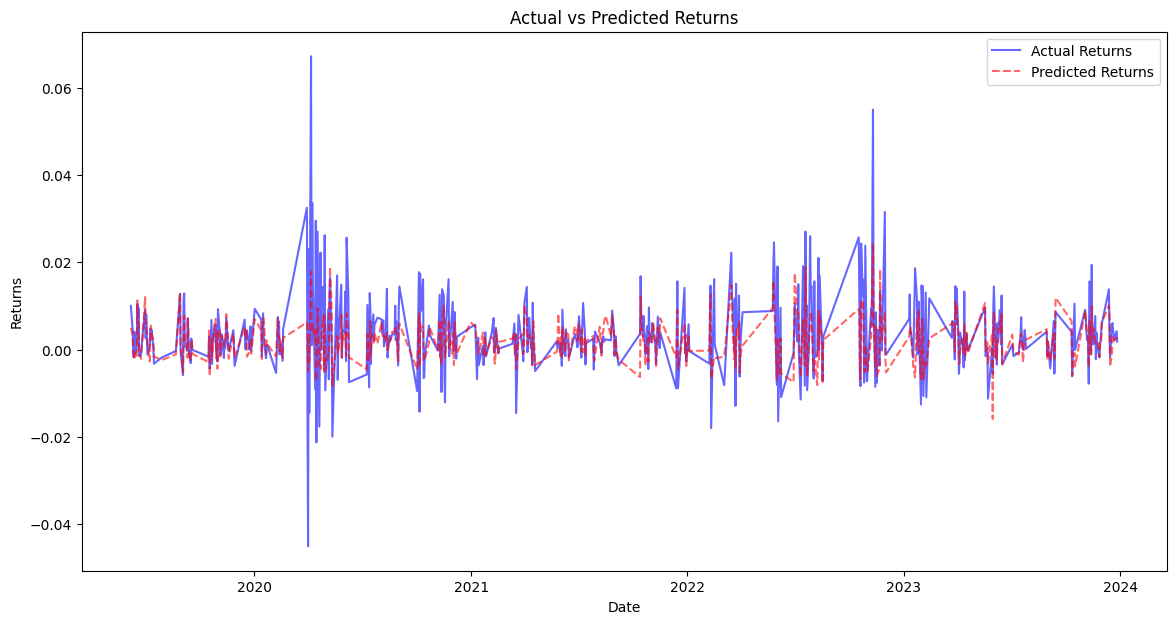

In [ ]:
y_pred_test = RF_regressor.predict(X_regression_test)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual Returns': y_price_test.values,
    'Predicted Returns': y_pred_test
}, index=y_price_test.index)

# Plot the actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual Returns'], label='Actual Returns', color='blue', alpha=0.6)
plt.plot(comparison_df['Predicted Returns'], label='Predicted Returns', color='red', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.0040907300331628135
Root Mean Squared Error: 0.006703953445566726


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Gradient Boosting prediction

In [ ]:
# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                         max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(X_regression, y_ret)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GradientBoostingRegressor(random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


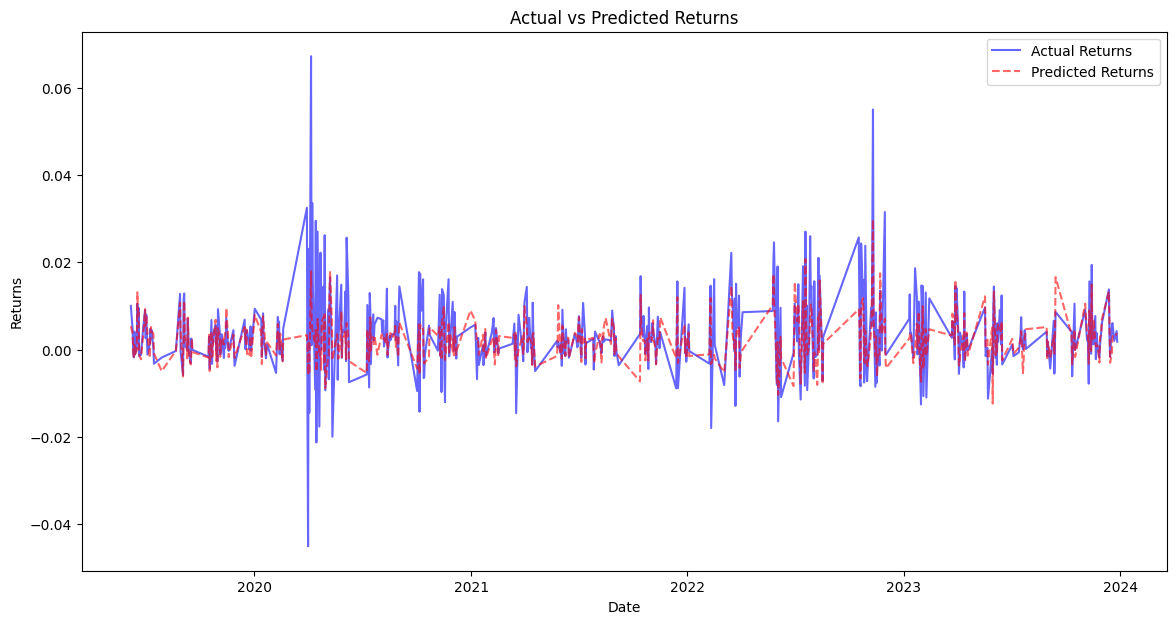

In [ ]:
y_pred_test = gb_regressor.predict(X_regression_test)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual Returns': y_price_test.values,
    'Predicted Returns': y_pred_test
}, index=y_price_test.index)

# Plot the actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual Returns'], label='Actual Returns', color='blue', alpha=0.6)
plt.plot(comparison_df['Predicted Returns'], label='Predicted Returns', color='red', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.004076055953270142
Root Mean Squared Error: 0.006617830266962444


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### XGBoost  prediction

In [ ]:
# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                                  max_depth = 5, n_estimators = 100, random_state=42)

# Train the model
xgb_regressor.fit(X_regression, y_ret)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

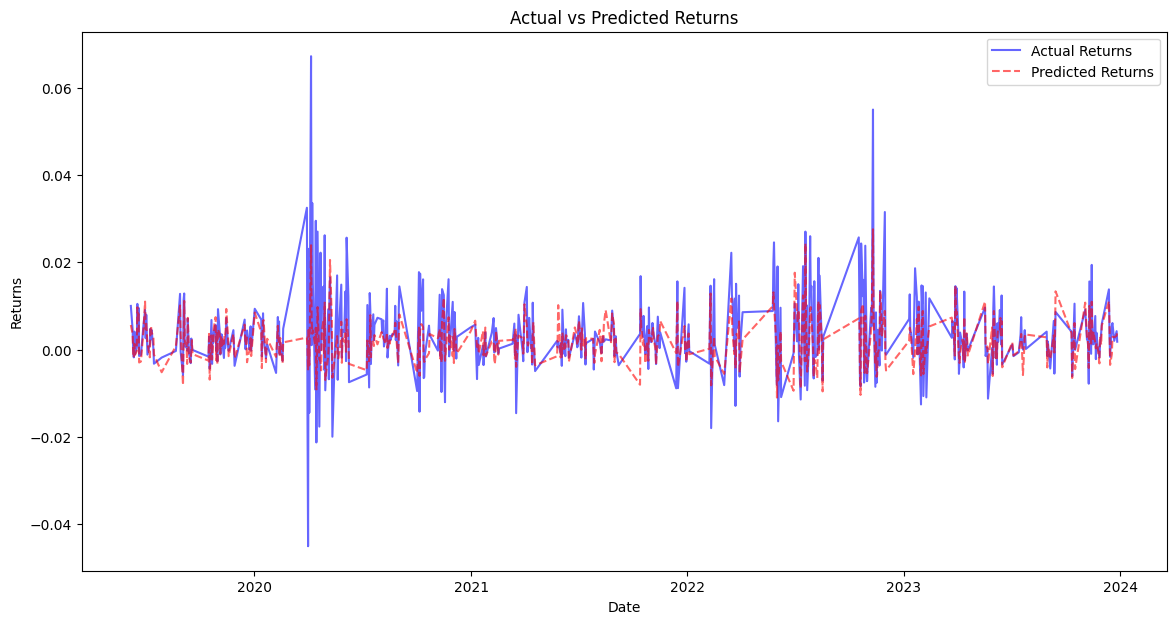

In [ ]:
y_pred_test = xgb_regressor.predict(X_regression_test)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual Returns': y_price_test.values,
    'Predicted Returns': y_pred_test
}, index=y_price_test.index)

# Plot the actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual Returns'], label='Actual Returns', color='blue', alpha=0.6)
plt.plot(comparison_df['Predicted Returns'], label='Predicted Returns', color='red', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_price_test, y_pred_test)
rmse = mean_squared_error(y_price_test, y_pred_test, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.004083921949725975
Root Mean Squared Error: 0.0065076300760711445


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Stacking

##### 2 base model

In [ ]:
# Initialize base regressors
reg_rf = RandomForestRegressor()
reg_gb = XGBRegressor()

# Create a stacking regressor with only two base models
estimators = [
    ('rf', reg_rf),
    ('gb', reg_gb)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor()
)

# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Regression model evaluation
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.004481030852666959
Root Mean Squared Error: 0.006937512901685406


##### 3 base model

In [ ]:

# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_mlp = RandomForestRegressor()

# Create a stacking regressor with three base models
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('mlp', reg_mlp)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=  RandomForestRegressor()  # You can adjust the kernel and other hyperparameters
)

# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Regression model evaluation
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 14
[LightGBM] [Info] Start training from score 0.003697


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start traini

In [ ]:
# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_ridge = Ridge(alpha=1.0)  # Initialize the Ridge regressor

# Create a stacking regressor with the base models including Ridge
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('mlp', reg_mlp),
    ('ridge', reg_ridge)  # Add Ridge regressor to the estimators
]

# Initialize the Stacking Regressor with the base models and a final estimator
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor()  # This is the final estimator that combines the base models' predictions
)



# Train the stacking regressor
stacking_reg.fit(X_regression, y_ret)

# Make predictions on the test set
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Evaluate the regression model
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)

# Print the error metrics
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 14
[LightGBM] [Info] Start training from score 0.003697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start traini

##### 4 base model

In [ ]:
# Initialize base regressors
reg_lgbm = LGBMRegressor()
reg_xgb = XGBRegressor()
reg_ridge = Ridge(alpha=1.0)
reg_mlp = RandomForestRegressor()

# Create a stacking regressor with the base models
estimators = [
    ('lgbm', reg_lgbm),
    ('xgb', reg_xgb),
    ('rf', reg_rf),
    ('ridge', reg_ridge),
    ('mlp', reg_mlp)  # Add MLPRegressor to the stack
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=42)  # Adjust as needed
)

# Assuming X_regression, y_ret are defined and hold your training data
stacking_reg.fit(X_regression, y_ret)

# Assuming X_regression_test holds your test features
y_pred_test_stacking = stacking_reg.predict(X_regression_test)

# Calculate and print error metrics
mae = mean_absolute_error(y_price_test, y_pred_test_stacking)
rmse = mean_squared_error(y_price_test, y_pred_test_stacking, squared=False)
print("Stacking Regressor Report:")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 14
[LightGBM] [Info] Start training from score 0.003697


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start training from score 0.003732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 14
[LightGBM] [Info] Start traini

### Developing a High-Volatility Trading Strategy Using a Stacked Machine Learning Model

In [ ]:

estimators = [('sgd', SGDClassifier(loss='modified_huber',shuffle=True, random_state=101)),('ada', make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=15,learning_rate=0.5))),
               ('rdg', make_pipeline(StandardScaler(),RidgeClassifier())),('knn', make_pipeline(StandardScaler(),KNeighborsClassifier(algorithm='brute', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=55, p=2,
           weights='uniform'))),('logit', make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',C=1.2,solver='liblinear',fit_intercept=True,intercept_scaling=2.1))),('CAT', make_pipeline(StandardScaler(),CatBoostClassifier(iterations=2, learning_rate=1, depth=2)))]

build_model= StackingClassifier(estimators=estimators, final_estimator=SVC())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

reg_data = train_data[train_data['Regime'] == 2 ]


y_sig= reg_data['Signal']

X_reg= reg_data.drop(columns=['Adj Close','Regime','Signal','Returns','Volatility','Fed_Sentiment_score'])

X_reg = X_reg[['Volume','SMA','RSI','50_MA','200_MA','OBV','CCI','ATR','Stochastic_oscillator','MACD','Signal_Line','Middle_Band','Upper_Band','Lower_Band']]


# Building the model for data
lstm_model_alphabet = build_model.fit(X_reg,y_sig)

0:	learn: 0.2959452	total: 1.06ms	remaining: 1.06ms
1:	learn: 0.2548372	total: 3.32ms	remaining: 0us
0:	learn: 0.2937696	total: 688us	remaining: 688us
1:	learn: 0.2269236	total: 1.39ms	remaining: 0us
0:	learn: 0.2916767	total: 673us	remaining: 673us
1:	learn: 0.1979003	total: 1.64ms	remaining: 0us
0:	learn: 0.3061225	total: 625us	remaining: 625us
1:	learn: 0.2629431	total: 1.2ms	remaining: 0us
0:	learn: 0.3133817	total: 650us	remaining: 650us
1:	learn: 0.2094230	total: 1.25ms	remaining: 0us
0:	learn: 0.2933306	total: 646us	remaining: 646us
1:	learn: 0.2481802	total: 1.23ms	remaining: 0us


"apply_strategy" uses a classifier (clf_regime) to predict market regimes and then applies different strategies depending on the regime. In a high volatility regime, it uses a signal-based strategy; in a low or medium volatility regime, it uses a price prediction model to decide on trades.

In [ ]:
def apply_strategy(data, clf_regime, model_signal, model_price):
    # Predict the volatility regime
    regime_prediction = clf_regime.predict(data)

    # Prepare the array to hold the trading signals
    signals = np.zeros(len(data), dtype=int)

    for i in range(len(data)):
        current_data = data.iloc[i:i+1].drop(columns=['Volatility','Fed_Sentiment_score'],axis =1)
        if regime_prediction[i] == 2:  # High volatility
            # Use the signal construction model
            signals[i] = np.sign(model_signal.predict(current_data)[0])
        else:  # Low or medium volatility
            # Use the price prediction model to predict the next period's price
            predicted_ret = model_price.predict(current_data)[0]
            # Compare the predicted future price to the current price
            if predicted_ret > 0:
                signals[i] = 1  # Buy if the price is predicted to increase
            else:
                signals[i] = -1  # Sell if the price is predicted to decrease

    return signals

In [ ]:
# Generate signals based on the strategy
signals= apply_strategy(X_test, stacking_clf ,build_model, xgb_regressor )


In [ ]:
signals=np.where(signals == 1, -1, np.where(signals == -1, 1, signals))

## Simulation and Performance Analysis of Trading Strategies with Sharpe Ratio Evaluation

 Signals are now generated for the test dataset, and a function calculate_cumulative_investment_value is used to simulate trading based on these signals, calculating the cumulative value of the investment over time.

In [ ]:
def calculate_cumulative_investment_value(signals, stock_prices, initial_investment):
    cash = initial_investment
    stock_held = 0
    investment_value = []

    for i in range(len(signals)):
        price = stock_prices.iloc[i]
        signal = signals[i]

        if signal == 1 and cash >= price:  # Buy signal and have enough cash to buy at least one stock
            num_stocks_to_buy = cash // price  # Calculate the number of stocks to buy
            stock_held += num_stocks_to_buy  # Increase the stock held
            cash -= num_stocks_to_buy * price  # Decrease the cash by the amount spent on stocks
        elif signal == -1 and stock_held > 0:  # Sell signal and have stocks to sell
            cash += stock_held * price  # Increase cash by selling all stocks held
            stock_held = 0  # Reset stock held to 0 after selling

        # Calculate current value of investment
        current_value = cash + stock_held * price  # Cash + value of stocks held
        investment_value.append(current_value)  # Append the current value to the investment value list

    return investment_value


In [ ]:
initial_inv=100000

In [ ]:
portfolio_values = calculate_cumulative_investment_value(signals, test_data['Adj Close'], initial_inv)

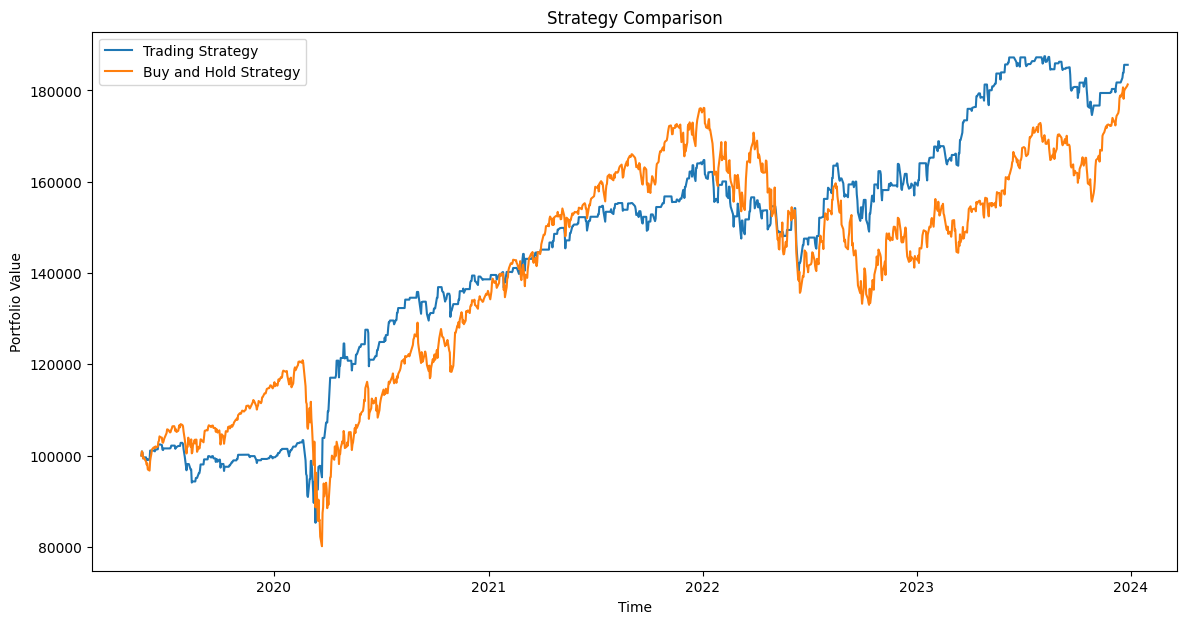

In [ ]:
# Compute the buy-and-hold strategy values
buy_and_hold_values = initial_inv * test_data['Adj Close'] / test_data['Adj Close'].iloc[0]

# Plot the portfolio values of both strategies
plt.figure(figsize=(14, 7))
plt.plot(test_data.index,portfolio_values, label='Trading Strategy')
plt.plot(test_data.index,buy_and_hold_values.values, label='Buy and Hold Strategy')
plt.title('Strategy Comparison')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Comparing the new strategy to a simple buy and hold strategy

In [ ]:
# Calculate daily returns for both strategies
strategy_returns = np.diff(portfolio_values) / portfolio_values[:-1]
buy_and_hold_returns = test_data['Adj Close'].pct_change().dropna()

# Calculate the Sharpe ratio for both strategies
strategy_sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)
buy_and_hold_sharpe_ratio = np.mean(buy_and_hold_returns) / np.std(buy_and_hold_returns) * np.sqrt(252)

print(f"Trading Strategy Sharpe Ratio: {strategy_sharpe_ratio}")
print(f"Buy and Hold Strategy Sharpe Ratio: {buy_and_hold_sharpe_ratio}")




Trading Strategy Sharpe Ratio: 0.9228617100735558
Buy and Hold Strategy Sharpe Ratio: 0.7086379174521442


**Interpretation:**

Significant improvements in both returns and the Sharpe ratio are evident when comparing the two strategies. This can be interpreted as underscoring the importance of incorporating Federal Reserve releases into the trading strategy and recognizing their substantial influence on the overall dynamics of the financial market.



# Conclusion

In this project, we embarked on an ambitious journey to craft a trading strategy tailored to the nuances of market dynamics from the ground up. Initially, our focus was squarely on analyzing returns volatility, deliberately excluding sentiment scores derived from Federal Reserve releases. This initial approach yielded results that, frankly, did not surpass the performance of a simple buy-and-hold strategy, highlighting the limitation of omitting sentiment analysis in our model.

Recognizing the potential shortfall, we pivoted in the second phase of our project to integrate the sentiment scores into our strategy. This inclusion marked a significant turning point, as we observed marked improvements in our strategy's performance. This enhancement underscored the critical influence of Federal Reserve communications on financial markets and the value of sentiment analysis in decoding this impact.

Reflecting on our journey, it's clear that while the project achieved respectable outcomes, there's a wealth of opportunity for further refinement and enhancement. Future avenues for improvement could include:

- **Enhancing Sentiment Analysis**: Innovating more sophisticated methods for sentiment analysis could provide deeper insights into the emotional undercurrents of market communications.
- **Feature Expansion**: Enriching our dataset with additional features could unveil new dimensions of market behavior, offering a richer tapestry for analysis.
- **Model Parameter Optimization**: A more nuanced selection of model parameters could fine-tune our strategy's effectiveness, potentially unlocking higher levels of performance.

This project, in its essence, has been a profound exploration of the intersection between market sentiment and trading strategy effectiveness. The lessons learned and the results obtained lay a foundation for further research, pointing towards an exciting horizon of possibilities for enhancing trading strategies in the complex world of financial markets.
